

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## Configuration


In [1]:
%%bash
 
# pip install -U ipyparams 
#pip install -U tensorflow_hub 
#pip install -U ipython
# pip install -U pymysql pyodbc
# pip install -U fasttext
# pip install -U seaborn

In [2]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image 

base_path = os.path.abspath('/tf/eipi10/jian-xu3/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# set gpu memory
qtf.utils.set_gpu_memory_growth()

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.10) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
%reload_ext autoreload

### Initial Parameters

In [4]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False) 

output_path = os.path.abspath('./output')
data_name = 'cifar10'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

notebook_name_params = qbz95.utils.get_notebook_name().split('.')[0].split('_')
train_image_count =  int(notebook_name_params[3])
use_data_augmentation = True if len(notebook_name_params)>=5 and notebook_name_params[4]=='aug' else False

params = {
    'data_name': data_name,
    'data_path': data_path,
    'train_image_count':train_image_count,
    'use_data_augmentation': use_data_augmentation,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(train_image_count*len(classes)/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': False,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },    
    'pretrained_callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': False,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': False,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': False,
            'schedule': lr_schedule,            
        }             
    },
    'fine_tune_callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': False,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        }            
    },    
    'model_params':{
        'mlp':{'dropout':0.1, 'layer_count':1, 'units':128, 'epochs':90},
        'lenet':{'dropout':0.2, 'epochs':90},
        'custom':{'dropout':0.2, 'epochs':90},
        'vgg':{'dropout':0.1, 'epochs':90},
        'resnet':{'dropout':0.2, 'epochs':90},
        'pretrained':{'dropout':0.2, 'epochs':20, 'learning_rate':0.0001}        
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
model_results.clear()

2022-08-16 08:28:47,699: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/results.json


In [5]:
params.use_data_augmentation

False

## Get Data

### Download Data 

In [6]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# train_images = train_images/255.0   
# test_images = test_images/255.0   

train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


In [7]:
if params.train_image_count*len(classes)<len(train_images):
    _, train_images, _, train_labels = train_test_split(train_images, train_labels, test_size=params.train_image_count*10, random_state=42)

    print(train_images.shape, train_labels.shape)
    print(test_images.shape, test_labels.shape)

(10000, 32, 32, 3) (10000,)
(10000, 32, 32, 3) (10000,)


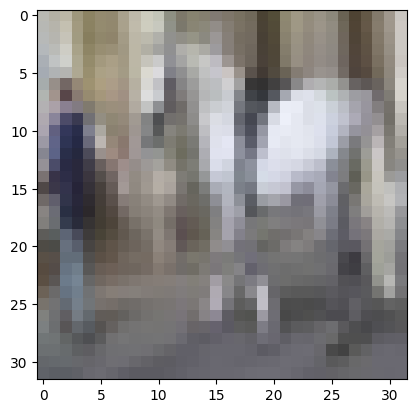

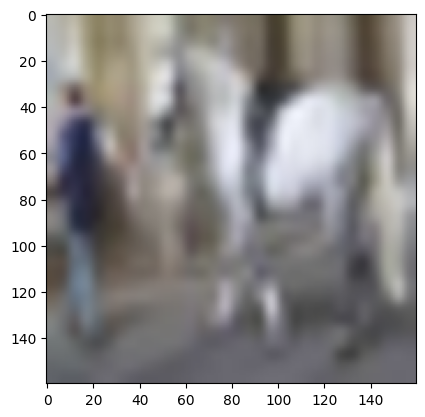

(32, 32, 3) (160, 160, 3)


In [8]:
def resize_image(image, shape=None):
    img = Image.fromarray(image)
    if shape is not None:
        img = img.resize(shape)
    image1 = np.asarray(img)
    return image1

def resize_images(images, shape=None):
    images1 = [resize_image(image, shape) for image in images]
    images1 = np.array(images1)
    return images1

input_shape=(160, 160) 
images = train_images[0:10]
images1 = resize_images(images, input_shape)

image_array = images[0]
plt.imshow(image_array)
plt.show()
 
image_array1 = images1[0]
plt.imshow(image_array1)
plt.show()

print(image_array.shape, image_array1.shape) 
# np.testing.assert_array_almost_equal(image_array, image_array1)

In [9]:
# train_images = resize_images(train_images, input_shape)
# test_images = resize_images(test_images, input_shape)

# print(train_images.shape, type(train_images), train_images.dtype)
# print(test_images.shape, type(test_images), test_images.dtype) 



### Data Explore 

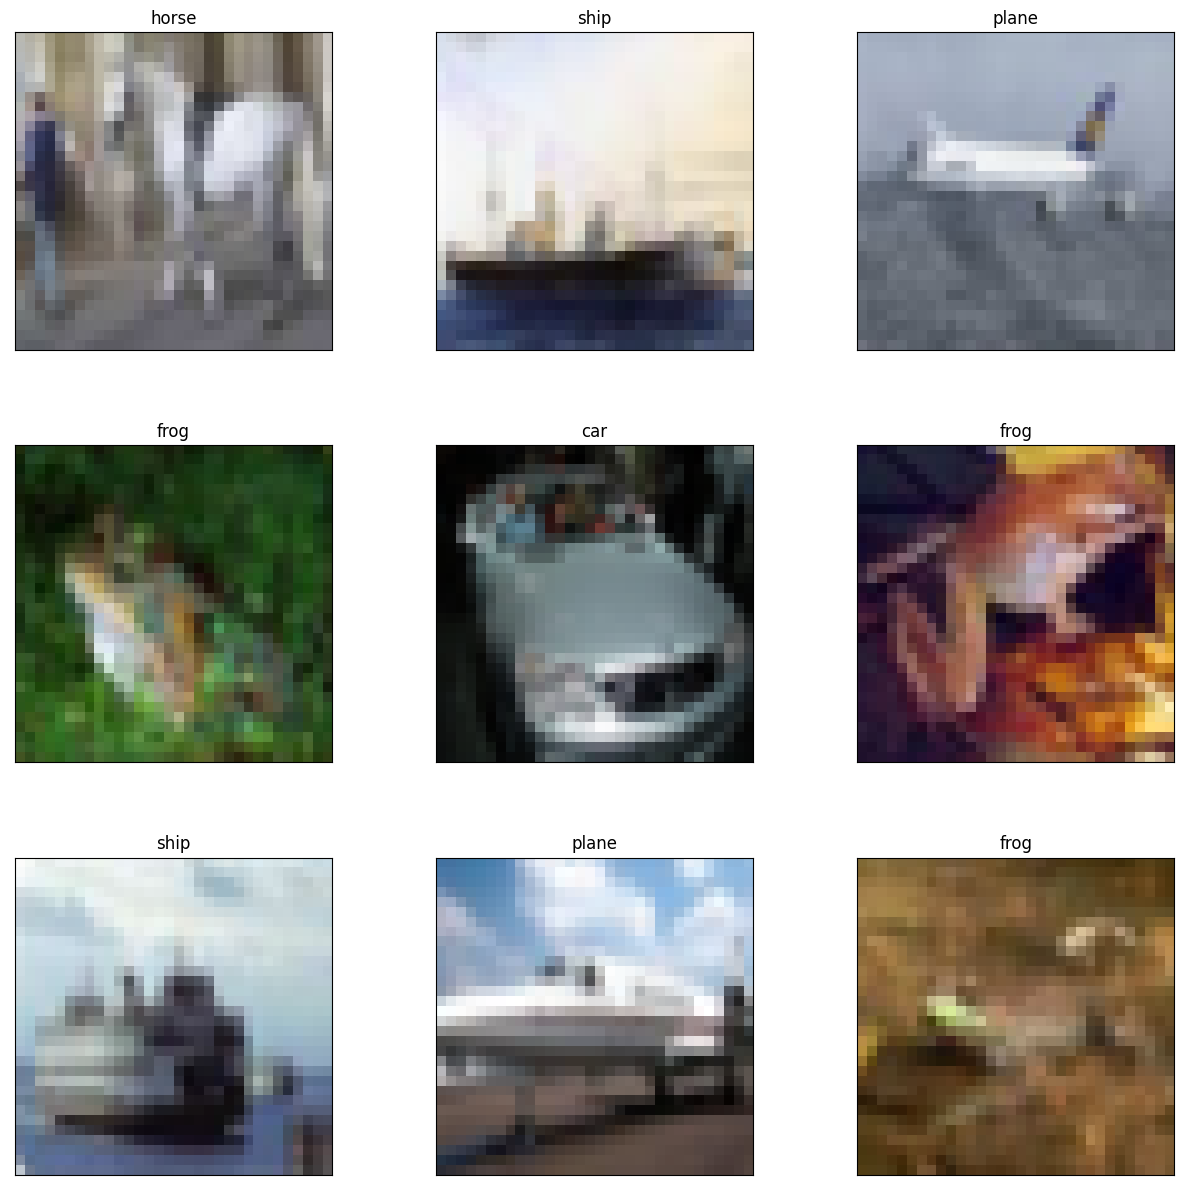

In [10]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=3, figsize=(12, 12))

### Class Distribution

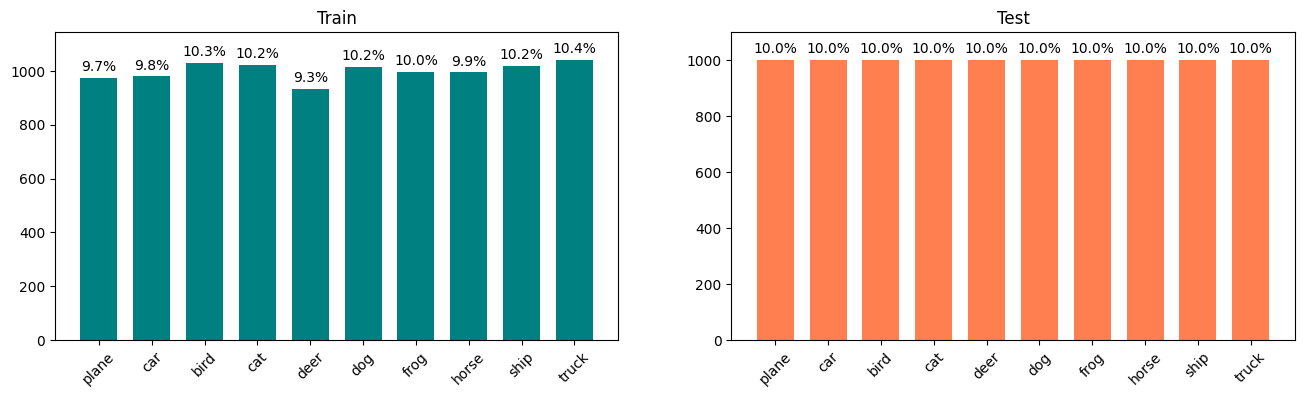

In [11]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## Prepare Data


### Raw Data


In [12]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [13]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [14]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 32, 32, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(32,), dtype=tf.uint8, name=None))

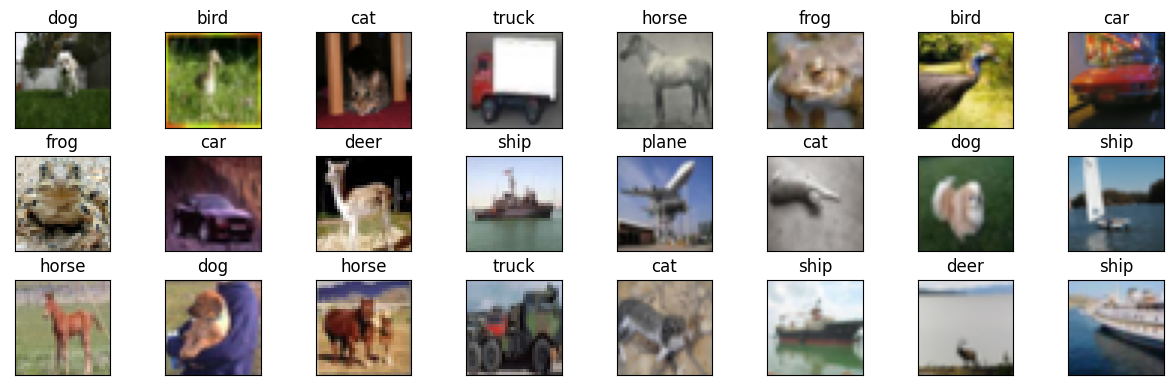

In [15]:
qtf.utils.show_images(sample_images.numpy(), sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### Data Augmentation

In [16]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

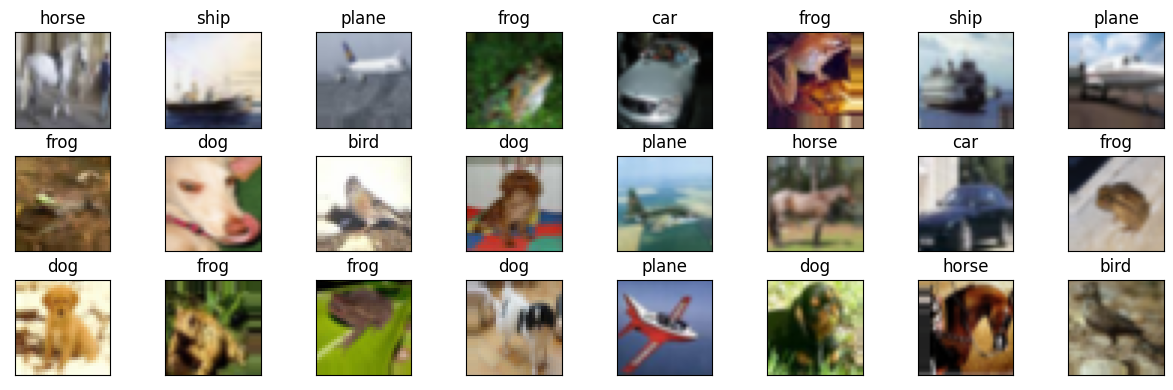

In [17]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

see orgin images

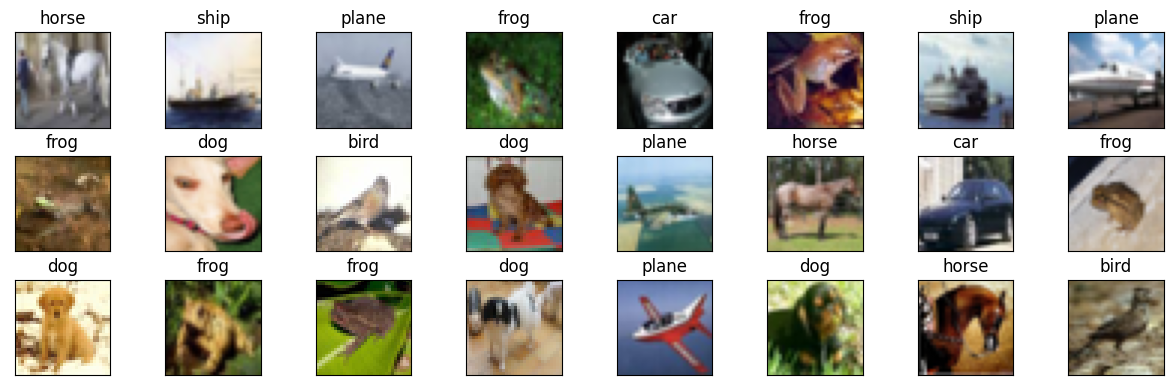

In [18]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

create data augment dataset

In [19]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [20]:
print(f'use_data_augmentation = {params.use_data_augmentation}')
if params.use_data_augmentation:
    datasets = augment_datasets
else:
    datasets = raw_datasets

use_data_augmentation = False


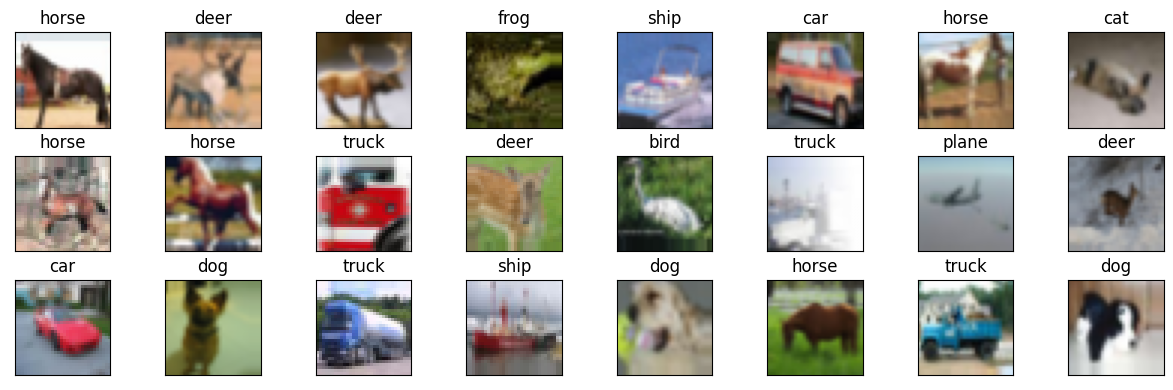

In [21]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 



##  Models



In [22]:
rescale = tf.keras.layers.Rescaling(1./255.0, offset=0)

### MLP

2022-08-16 08:28:57,686: INFO: model_params.mlp1.dropout=0.1
2022-08-16 08:28:57,687: INFO: model_params.mlp1.layer_count=1
2022-08-16 08:28:57,688: INFO: model_params.mlp1.units=128
2022-08-16 08:28:57,726: INFO: learning_rate=0.001
2022-08-16 08:28:57,727: INFO: model_params.mlp1.clip_value=None
2022-08-16 08:28:57,735: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1


Model: "mlp1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               393344    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 394,634
Trainable params: 394,634
Non-trainable 

2022-08-16 08:28:57,749: INFO: model_params.mlp1.epochs=90
2022-08-16 08:28:57,750: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1, monitor=val_accuracy)
2022-08-16 08:28:57,750: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-16 08:28:57,751: INFO: use LearningRateScheduler()
2022-08-16 08:28:57,752: INFO: steps_per_epoch=312
2022-08-16 08:28:57,752: INFO: start training
2022-08-16 08:28:57,753: INFO: use_class_weight=False


Epoch 1/90
306/312 [============================>.] - ETA: 0s - loss: 2.1192 - accuracy: 0.2168INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


2022-08-16 08:29:00,546: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


312/312 [==============================] - 3s 7ms/step - loss: 2.1186 - accuracy: 0.2170 - val_loss: 2.0096 - val_accuracy: 0.2426 - lr: 0.0010
Epoch 2/90
311/312 [============================>.] - ETA: 0s - loss: 1.9621 - accuracy: 0.2703INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


2022-08-16 08:29:02,440: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


312/312 [==============================] - 2s 6ms/step - loss: 1.9626 - accuracy: 0.2703 - val_loss: 1.9452 - val_accuracy: 0.3065 - lr: 0.0010
Epoch 3/90
300/312 [===========================>..] - ETA: 0s - loss: 1.8930 - accuracy: 0.3076INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


2022-08-16 08:29:04,369: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


312/312 [==============================] - 2s 6ms/step - loss: 1.8956 - accuracy: 0.3053 - val_loss: 1.8881 - val_accuracy: 0.3371 - lr: 0.0010
Epoch 4/90
306/312 [============================>.] - ETA: 0s - loss: 1.8721 - accuracy: 0.3126INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


2022-08-16 08:29:06,241: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


312/312 [==============================] - 2s 6ms/step - loss: 1.8729 - accuracy: 0.3119 - val_loss: 1.8614 - val_accuracy: 0.3399 - lr: 0.0010
Epoch 5/90
312/312 [==============================] - 1s 4ms/step - loss: 1.8487 - accuracy: 0.3236 - val_loss: 1.8754 - val_accuracy: 0.3361 - lr: 0.0010
Epoch 6/90
300/312 [===========================>..] - ETA: 0s - loss: 1.8391 - accuracy: 0.3252INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


2022-08-16 08:29:09,333: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


312/312 [==============================] - 2s 6ms/step - loss: 1.8412 - accuracy: 0.3233 - val_loss: 1.8290 - val_accuracy: 0.3428 - lr: 0.0010
Epoch 7/90
299/312 [===========================>..] - ETA: 0s - loss: 1.8222 - accuracy: 0.3332INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


2022-08-16 08:29:11,258: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


312/312 [==============================] - 2s 6ms/step - loss: 1.8241 - accuracy: 0.3310 - val_loss: 1.8511 - val_accuracy: 0.3448 - lr: 0.0010
Epoch 8/90
297/312 [===========================>..] - ETA: 0s - loss: 1.8108 - accuracy: 0.3315INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


2022-08-16 08:29:13,514: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


312/312 [==============================] - 2s 7ms/step - loss: 1.8110 - accuracy: 0.3310 - val_loss: 1.8244 - val_accuracy: 0.3534 - lr: 0.0010
Epoch 9/90
312/312 [==============================] - 1s 4ms/step - loss: 1.7991 - accuracy: 0.3393 - val_loss: 1.8362 - val_accuracy: 0.3471 - lr: 0.0010
Epoch 10/90
312/312 [==============================] - 1s 4ms/step - loss: 1.7926 - accuracy: 0.3417 - val_loss: 1.8322 - val_accuracy: 0.3467 - lr: 0.0010
Epoch 11/90
312/312 [==============================] - 1s 4ms/step - loss: 1.7858 - accuracy: 0.3487 - val_loss: 1.8232 - val_accuracy: 0.3505 - lr: 0.0010
Epoch 12/90
312/312 [==============================] - 1s 4ms/step - loss: 1.7826 - accuracy: 0.3419 - val_loss: 1.8278 - val_accuracy: 0.3435 - lr: 0.0010
Epoch 13/90
312/312 [==============================] - 1s 4ms/step - loss: 1.7690 - accuracy: 0.3466 - val_loss: 1.8526 - val_accuracy: 0.3405 - lr: 0.0010
Epoch 14/90
312/312 [==============================] - 1s 4ms/step - loss: 1.

2022-08-16 08:29:28,021: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


312/312 [==============================] - 2s 6ms/step - loss: 1.7415 - accuracy: 0.3640 - val_loss: 1.7728 - val_accuracy: 0.3608 - lr: 0.0010
Epoch 20/90
312/312 [==============================] - 1s 4ms/step - loss: 1.7366 - accuracy: 0.3665 - val_loss: 1.7985 - val_accuracy: 0.3570 - lr: 0.0010
Epoch 21/90
312/312 [==============================] - 1s 4ms/step - loss: 1.7303 - accuracy: 0.3660 - val_loss: 1.8299 - val_accuracy: 0.3382 - lr: 0.0010
Epoch 22/90
312/312 [==============================] - 1s 4ms/step - loss: 1.7260 - accuracy: 0.3662 - val_loss: 1.8164 - val_accuracy: 0.3516 - lr: 0.0010
Epoch 23/90
312/312 [==============================] - 1s 4ms/step - loss: 1.7130 - accuracy: 0.3729 - val_loss: 1.7968 - val_accuracy: 0.3512 - lr: 0.0010
Epoch 24/90
312/312 [==============================] - 1s 4ms/step - loss: 1.7186 - accuracy: 0.3745 - val_loss: 1.8121 - val_accuracy: 0.3391 - lr: 0.0010
Epoch 25/90
312/312 [==============================] - 1s 4ms/step - loss: 1

2022-08-16 08:29:48,087: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


312/312 [==============================] - 2s 6ms/step - loss: 1.6625 - accuracy: 0.3942 - val_loss: 1.7493 - val_accuracy: 0.3722 - lr: 3.1623e-04
Epoch 00036: Still keep learning rate 0.0003162 instead of 0.001
Epoch 36/90
312/312 [==============================] - 1s 4ms/step - loss: 1.6489 - accuracy: 0.4018 - val_loss: 1.7478 - val_accuracy: 0.3716 - lr: 3.1623e-04
Epoch 00037: Still keep learning rate 0.0003162 instead of 0.001
Epoch 37/90
305/312 [============================>.] - ETA: 0s - loss: 1.6430 - accuracy: 0.4036INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


2022-08-16 08:29:51,154: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


312/312 [==============================] - 2s 6ms/step - loss: 1.6447 - accuracy: 0.4021 - val_loss: 1.7421 - val_accuracy: 0.3737 - lr: 3.1623e-04
Epoch 00038: Still keep learning rate 0.0003162 instead of 0.001
Epoch 38/90
303/312 [============================>.] - ETA: 0s - loss: 1.6406 - accuracy: 0.4041INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


2022-08-16 08:29:53,035: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


312/312 [==============================] - 2s 6ms/step - loss: 1.6432 - accuracy: 0.4022 - val_loss: 1.7415 - val_accuracy: 0.3752 - lr: 3.1623e-04
Epoch 00039: Still keep learning rate 0.0003162 instead of 0.001
Epoch 39/90
308/312 [============================>.] - ETA: 0s - loss: 1.6407 - accuracy: 0.4006INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


2022-08-16 08:29:54,868: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


312/312 [==============================] - 2s 6ms/step - loss: 1.6399 - accuracy: 0.4005 - val_loss: 1.7434 - val_accuracy: 0.3777 - lr: 3.1623e-04
Epoch 00040: Still keep learning rate 0.0003162 instead of 0.001
Epoch 40/90
312/312 [==============================] - 1s 4ms/step - loss: 1.6403 - accuracy: 0.4010 - val_loss: 1.7451 - val_accuracy: 0.3723 - lr: 3.1623e-04
Epoch 00041: Still keep learning rate 0.0003162 instead of 0.001
Epoch 41/90
312/312 [==============================] - 1s 4ms/step - loss: 1.6354 - accuracy: 0.4037 - val_loss: 1.7431 - val_accuracy: 0.3755 - lr: 3.1623e-04
Epoch 00042: Still keep learning rate 0.0003162 instead of 0.001
Epoch 42/90
312/312 [==============================] - 1s 4ms/step - loss: 1.6339 - accuracy: 0.4029 - val_loss: 1.7411 - val_accuracy: 0.3775 - lr: 3.1623e-04
Epoch 00043: Still keep learning rate 0.0003162 instead of 0.001
Epoch 43/90
312/312 [==============================] - 1s 4ms/step - loss: 1.6267 - accuracy: 0.4029 - val_loss:

2022-08-16 08:30:24,860: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


312/312 [==============================] - 2s 6ms/step - loss: 1.5902 - accuracy: 0.4213 - val_loss: 1.7401 - val_accuracy: 0.3783 - lr: 1.0000e-04
Epoch 64/90
301/312 [===========================>..] - ETA: 0s - loss: 1.5887 - accuracy: 0.4236
Epoch 64: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
312/312 [==============================] - 1s 4ms/step - loss: 1.5911 - accuracy: 0.4216 - val_loss: 1.7416 - val_accuracy: 0.3763 - lr: 3.1623e-05
Epoch 00065: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 65/90
312/312 [==============================] - 1s 4ms/step - loss: 1.5882 - accuracy: 0.4234 - val_loss: 1.7400 - val_accuracy: 0.3747 - lr: 3.1623e-05
Epoch 00066: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 66/90
312/312 [==============================] - 1s 4ms/step - loss: 1.5882 - accuracy: 0.4156 - val_loss: 1.7401 - val_accuracy: 0.3756 - lr: 3.1623e-05
Epoch 00067: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 67/90
31

2022-08-16 08:30:47,475: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


312/312 [==============================] - 2s 6ms/step - loss: 1.5915 - accuracy: 0.4201 - val_loss: 1.7401 - val_accuracy: 0.3788 - lr: 1.0000e-05
Epoch 00082: Still keep learning rate 1e-05 instead of 0.0001
Epoch 82/90
312/312 [==============================] - 1s 4ms/step - loss: 1.5819 - accuracy: 0.4211 - val_loss: 1.7402 - val_accuracy: 0.3785 - lr: 1.0000e-05
Epoch 00083: Still keep learning rate 1e-05 instead of 0.0001
Epoch 83/90
312/312 [==============================] - 1s 4ms/step - loss: 1.5819 - accuracy: 0.4239 - val_loss: 1.7401 - val_accuracy: 0.3787 - lr: 1.0000e-05
Epoch 00084: Still keep learning rate 1e-05 instead of 0.0001
Epoch 84/90
312/312 [==============================] - 1s 4ms/step - loss: 1.5859 - accuracy: 0.4236 - val_loss: 1.7399 - val_accuracy: 0.3784 - lr: 1.0000e-05
Epoch 00085: Still keep learning rate 1e-05 instead of 0.0001
Epoch 85/90
312/312 [==============================] - 1s 4ms/step - loss: 1.5849 - accuracy: 0.4219 - val_loss: 1.7402 - va

2022-08-16 08:30:58,558: INFO: finish training [elapsed time: 120.81 seconds]


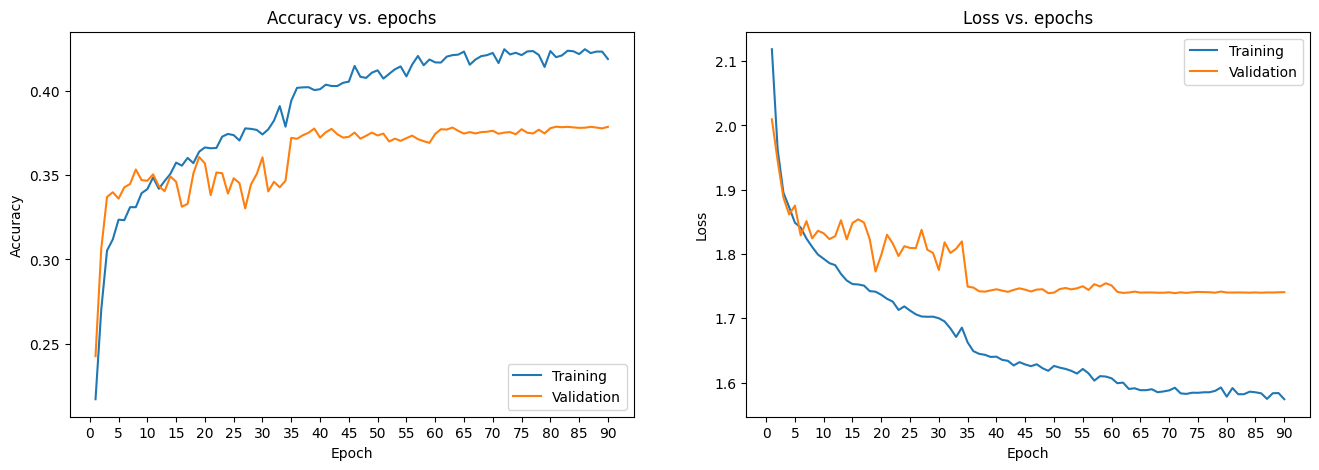

2022-08-16 08:30:58,945: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 0s 1ms/step


2022-08-16 08:31:02,554: INFO: test loss:1.7401
2022-08-16 08:31:02,555: INFO: test accuracy:0.3788
2022-08-16 08:31:02,556: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/results.json
2022-08-16 08:31:02,557: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/results.json
2022-08-16 08:31:02,558: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/default.generator
2022-08-16 08:31:02,559: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/default.generator


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------
313/313 [==============================] - 0s 1ms/step


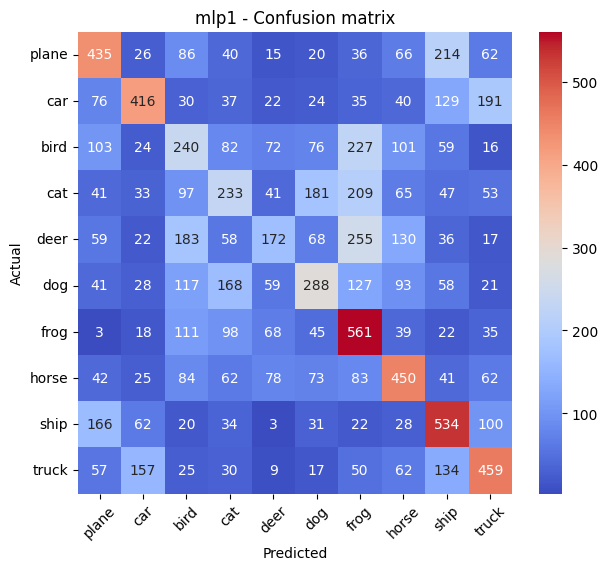

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  train_time  \
1       mlp1  cifar10_0816_cnt_1000.ipynb         394634       120.8   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-16 08:31      1.5023     1.7401          0.4654         0.3788   

   train_auc  test_auc  
1     0.8662    0.8141

In [23]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 




### LeNet

![image-20201019113632136](images/image-20201019113632136.png)


2022-08-16 08:31:03,957: INFO: model_params.lenet1.dropout=0.2
2022-08-16 08:31:04,048: INFO: learning_rate=0.001
2022-08-16 08:31:04,049: INFO: model_params.lenet1.clip_value=None
2022-08-16 08:31:04,055: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1


Model: "lenet1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 6)         456       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 6)        24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 6)        0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 6)         0    

2022-08-16 08:31:04,084: INFO: model_params.lenet1.epochs=90
2022-08-16 08:31:04,085: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1, monitor=val_accuracy)
2022-08-16 08:31:04,085: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-16 08:31:04,086: INFO: use LearningRateScheduler()
2022-08-16 08:31:04,086: INFO: steps_per_epoch=312
2022-08-16 08:31:04,087: INFO: start training
2022-08-16 08:31:04,088: INFO: use_class_weight=False


Epoch 1/90
312/312 [==============================] - ETA: 0s - loss: 2.0651 - accuracy: 0.2488

2022-08-16 08:31:09,108: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


2022-08-16 08:31:09,666: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


312/312 [==============================] - 6s 13ms/step - loss: 2.0651 - accuracy: 0.2488 - val_loss: 1.9023 - val_accuracy: 0.3102 - lr: 0.0010
Epoch 2/90
311/312 [============================>.] - ETA: 0s - loss: 1.7443 - accuracy: 0.3624

2022-08-16 08:31:12,995: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


2022-08-16 08:31:13,561: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


312/312 [==============================] - 4s 13ms/step - loss: 1.7442 - accuracy: 0.3625 - val_loss: 1.5504 - val_accuracy: 0.4489 - lr: 0.0010
Epoch 3/90
312/312 [==============================] - 2s 6ms/step - loss: 1.6123 - accuracy: 0.4110 - val_loss: 1.6197 - val_accuracy: 0.4190 - lr: 0.0010
Epoch 4/90
312/312 [==============================] - 2s 6ms/step - loss: 1.5046 - accuracy: 0.4537 - val_loss: 1.8599 - val_accuracy: 0.3719 - lr: 0.0010
Epoch 5/90
312/312 [==============================] - ETA: 0s - loss: 1.4407 - accuracy: 0.4786

2022-08-16 08:31:20,521: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


2022-08-16 08:31:21,083: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


312/312 [==============================] - 4s 12ms/step - loss: 1.4407 - accuracy: 0.4786 - val_loss: 1.4492 - val_accuracy: 0.4891 - lr: 0.0010
Epoch 6/90
312/312 [==============================] - 2s 6ms/step - loss: 1.3730 - accuracy: 0.5057 - val_loss: 1.6054 - val_accuracy: 0.4366 - lr: 0.0010
Epoch 7/90
312/312 [==============================] - 2s 6ms/step - loss: 1.3285 - accuracy: 0.5242 - val_loss: 1.6625 - val_accuracy: 0.4368 - lr: 0.0010
Epoch 8/90
312/312 [==============================] - 2s 6ms/step - loss: 1.2607 - accuracy: 0.5503 - val_loss: 1.6565 - val_accuracy: 0.4458 - lr: 0.0010
Epoch 9/90
312/312 [==============================] - 2s 6ms/step - loss: 1.2353 - accuracy: 0.5601 - val_loss: 1.9732 - val_accuracy: 0.3844 - lr: 0.0010
Epoch 10/90
312/312 [==============================] - 2s 6ms/step - loss: 1.1993 - accuracy: 0.5693 - val_loss: 2.7102 - val_accuracy: 0.3143 - lr: 0.0010
Epoch 11/90
312/312 [==============================] - 2s 6ms/step - loss: 1.17

2022-08-16 08:31:35,914: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


2022-08-16 08:31:36,469: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


312/312 [==============================] - 4s 12ms/step - loss: 1.1222 - accuracy: 0.5949 - val_loss: 1.4805 - val_accuracy: 0.5091 - lr: 0.0010
Epoch 13/90
312/312 [==============================] - 2s 7ms/step - loss: 1.1006 - accuracy: 0.6053 - val_loss: 2.5678 - val_accuracy: 0.3344 - lr: 0.0010
Epoch 14/90
312/312 [==============================] - 2s 7ms/step - loss: 1.0844 - accuracy: 0.6120 - val_loss: 1.8292 - val_accuracy: 0.4266 - lr: 0.0010
Epoch 15/90
310/312 [============================>.] - ETA: 0s - loss: 1.0474 - accuracy: 0.6218

2022-08-16 08:31:44,010: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


2022-08-16 08:31:44,587: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


312/312 [==============================] - 4s 13ms/step - loss: 1.0456 - accuracy: 0.6228 - val_loss: 1.2628 - val_accuracy: 0.5691 - lr: 0.0010
Epoch 16/90
312/312 [==============================] - 2s 6ms/step - loss: 1.0138 - accuracy: 0.6327 - val_loss: 1.3426 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 17/90
312/312 [==============================] - 2s 6ms/step - loss: 0.9856 - accuracy: 0.6444 - val_loss: 1.8905 - val_accuracy: 0.4692 - lr: 0.0010
Epoch 18/90
312/312 [==============================] - 2s 6ms/step - loss: 0.9719 - accuracy: 0.6507 - val_loss: 1.6558 - val_accuracy: 0.5055 - lr: 0.0010
Epoch 19/90
312/312 [==============================] - 2s 6ms/step - loss: 0.9477 - accuracy: 0.6622 - val_loss: 2.1699 - val_accuracy: 0.4233 - lr: 0.0010
Epoch 20/90
303/312 [============================>.] - ETA: 0s - loss: 0.9336 - accuracy: 0.6638

2022-08-16 08:31:55,616: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


2022-08-16 08:31:56,188: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


312/312 [==============================] - 4s 12ms/step - loss: 0.9337 - accuracy: 0.6628 - val_loss: 1.2835 - val_accuracy: 0.5759 - lr: 0.0010
Epoch 21/90
311/312 [============================>.] - ETA: 0s - loss: 0.9256 - accuracy: 0.6650

2022-08-16 08:31:59,345: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


2022-08-16 08:31:59,916: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


312/312 [==============================] - 4s 12ms/step - loss: 0.9253 - accuracy: 0.6652 - val_loss: 1.2405 - val_accuracy: 0.5808 - lr: 0.0010
Epoch 22/90
312/312 [==============================] - 2s 6ms/step - loss: 0.8949 - accuracy: 0.6740 - val_loss: 1.5506 - val_accuracy: 0.5274 - lr: 0.0010
Epoch 23/90
312/312 [==============================] - 2s 6ms/step - loss: 0.9047 - accuracy: 0.6728 - val_loss: 1.5277 - val_accuracy: 0.5377 - lr: 0.0010
Epoch 24/90
312/312 [==============================] - 2s 6ms/step - loss: 0.8737 - accuracy: 0.6869 - val_loss: 1.3946 - val_accuracy: 0.5563 - lr: 0.0010
Epoch 25/90
312/312 [==============================] - 2s 6ms/step - loss: 0.8507 - accuracy: 0.6949 - val_loss: 1.8257 - val_accuracy: 0.4843 - lr: 0.0010
Epoch 26/90
312/312 [==============================] - 2s 6ms/step - loss: 0.8548 - accuracy: 0.6950 - val_loss: 1.7492 - val_accuracy: 0.4813 - lr: 0.0010
Epoch 27/90
312/312 [==============================] - 2s 6ms/step - loss: 

2022-08-16 08:32:14,944: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


2022-08-16 08:32:15,542: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


312/312 [==============================] - 4s 13ms/step - loss: 0.8346 - accuracy: 0.7022 - val_loss: 1.2011 - val_accuracy: 0.5910 - lr: 0.0010
Epoch 29/90
312/312 [==============================] - 2s 6ms/step - loss: 0.8199 - accuracy: 0.7094 - val_loss: 1.4148 - val_accuracy: 0.5398 - lr: 0.0010
Epoch 30/90
312/312 [==============================] - ETA: 0s - loss: 0.8346 - accuracy: 0.7035

2022-08-16 08:32:20,674: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


2022-08-16 08:32:21,243: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


312/312 [==============================] - 4s 12ms/step - loss: 0.8346 - accuracy: 0.7035 - val_loss: 1.2182 - val_accuracy: 0.5919 - lr: 0.0010
Epoch 31/90
312/312 [==============================] - 2s 6ms/step - loss: 0.7959 - accuracy: 0.7168 - val_loss: 1.2964 - val_accuracy: 0.5722 - lr: 0.0010
Epoch 32/90
312/312 [==============================] - 2s 7ms/step - loss: 0.7734 - accuracy: 0.7222 - val_loss: 1.2720 - val_accuracy: 0.5859 - lr: 0.0010
Epoch 33/90
312/312 [==============================] - 2s 6ms/step - loss: 0.7679 - accuracy: 0.7265 - val_loss: 1.3432 - val_accuracy: 0.5779 - lr: 0.0010
Epoch 34/90
312/312 [==============================] - 2s 7ms/step - loss: 0.7523 - accuracy: 0.7305 - val_loss: 1.2774 - val_accuracy: 0.5868 - lr: 0.0010
Epoch 35/90
312/312 [==============================] - 2s 6ms/step - loss: 0.7481 - accuracy: 0.7322 - val_loss: 1.2883 - val_accuracy: 0.5827 - lr: 0.0010
Epoch 36/90
312/312 [==============================] - 2s 6ms/step - loss: 

2022-08-16 08:32:40,327: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


2022-08-16 08:32:40,892: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


312/312 [==============================] - 4s 12ms/step - loss: 0.7368 - accuracy: 0.7379 - val_loss: 1.2591 - val_accuracy: 0.5942 - lr: 0.0010
Epoch 40/90
312/312 [==============================] - 2s 6ms/step - loss: 0.7285 - accuracy: 0.7398 - val_loss: 1.2814 - val_accuracy: 0.5860 - lr: 0.0010
Epoch 41/90
312/312 [==============================] - 2s 6ms/step - loss: 0.7126 - accuracy: 0.7428 - val_loss: 1.3048 - val_accuracy: 0.5918 - lr: 0.0010
Epoch 42/90
312/312 [==============================] - 2s 6ms/step - loss: 0.7217 - accuracy: 0.7479 - val_loss: 1.8219 - val_accuracy: 0.4993 - lr: 0.0010
Epoch 43/90
310/312 [============================>.] - ETA: 0s - loss: 0.7090 - accuracy: 0.7496
Epoch 43: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
312/312 [==============================] - 2s 6ms/step - loss: 0.7085 - accuracy: 0.7499 - val_loss: 1.3016 - val_accuracy: 0.5875 - lr: 3.1623e-04
Epoch 00044: Still keep learning rate 0.0003162 instead of 0.001

2022-08-16 08:32:51,935: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


2022-08-16 08:32:52,512: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


312/312 [==============================] - 4s 13ms/step - loss: 0.6477 - accuracy: 0.7702 - val_loss: 1.2876 - val_accuracy: 0.6088 - lr: 3.1623e-04
Epoch 00045: Still keep learning rate 0.0003162 instead of 0.001
Epoch 45/90
312/312 [==============================] - 2s 6ms/step - loss: 0.6299 - accuracy: 0.7727 - val_loss: 1.2912 - val_accuracy: 0.6077 - lr: 3.1623e-04
Epoch 00046: Still keep learning rate 0.0003162 instead of 0.001
Epoch 46/90
312/312 [==============================] - 2s 6ms/step - loss: 0.6281 - accuracy: 0.7732 - val_loss: 1.2914 - val_accuracy: 0.6045 - lr: 3.1623e-04
Epoch 00047: Still keep learning rate 0.0003162 instead of 0.001
Epoch 47/90
308/312 [============================>.] - ETA: 0s - loss: 0.6121 - accuracy: 0.7836

2022-08-16 08:32:59,556: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


2022-08-16 08:33:00,124: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


312/312 [==============================] - 4s 12ms/step - loss: 0.6113 - accuracy: 0.7838 - val_loss: 1.2924 - val_accuracy: 0.6096 - lr: 3.1623e-04
Epoch 00048: Still keep learning rate 0.0003162 instead of 0.001
Epoch 48/90
312/312 [==============================] - 2s 7ms/step - loss: 0.6092 - accuracy: 0.7827 - val_loss: 1.2897 - val_accuracy: 0.6070 - lr: 3.1623e-04
Epoch 00049: Still keep learning rate 0.0003162 instead of 0.001
Epoch 49/90
312/312 [==============================] - 2s 7ms/step - loss: 0.6156 - accuracy: 0.7793 - val_loss: 1.3147 - val_accuracy: 0.6073 - lr: 3.1623e-04
Epoch 00050: Still keep learning rate 0.0003162 instead of 0.001
Epoch 50/90
312/312 [==============================] - 2s 6ms/step - loss: 0.6077 - accuracy: 0.7849 - val_loss: 1.2794 - val_accuracy: 0.6079 - lr: 3.1623e-04
Epoch 00051: Still keep learning rate 0.0003162 instead of 0.001
Epoch 51/90
306/312 [============================>.] - ETA: 0s - loss: 0.5976 - accuracy: 0.7906

2022-08-16 08:33:09,541: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


2022-08-16 08:33:10,108: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


312/312 [==============================] - 4s 12ms/step - loss: 0.5969 - accuracy: 0.7909 - val_loss: 1.2871 - val_accuracy: 0.6121 - lr: 3.1623e-04
Epoch 00052: Still keep learning rate 0.0003162 instead of 0.001
Epoch 52/90
312/312 [==============================] - 2s 6ms/step - loss: 0.5801 - accuracy: 0.7912 - val_loss: 1.3444 - val_accuracy: 0.6046 - lr: 3.1623e-04
Epoch 00053: Still keep learning rate 0.0003162 instead of 0.001
Epoch 53/90
312/312 [==============================] - 2s 6ms/step - loss: 0.5908 - accuracy: 0.7888 - val_loss: 1.3247 - val_accuracy: 0.6030 - lr: 3.1623e-04
Epoch 00054: Still keep learning rate 0.0003162 instead of 0.001
Epoch 54/90
312/312 [==============================] - 2s 6ms/step - loss: 0.5710 - accuracy: 0.7982 - val_loss: 1.3416 - val_accuracy: 0.6044 - lr: 3.1623e-04
Epoch 00055: Still keep learning rate 0.0003162 instead of 0.001
Epoch 55/90
312/312 [==============================] - 2s 6ms/step - loss: 0.5857 - accuracy: 0.7882 - val_loss

2022-08-16 08:33:23,133: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


2022-08-16 08:33:23,693: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


312/312 [==============================] - 4s 13ms/step - loss: 0.5720 - accuracy: 0.7974 - val_loss: 1.3007 - val_accuracy: 0.6142 - lr: 3.1623e-04
Epoch 00058: Still keep learning rate 0.0003162 instead of 0.001
Epoch 58/90
300/312 [===========================>..] - ETA: 0s - loss: 0.5675 - accuracy: 0.7966
Epoch 58: ReduceLROnPlateau reducing learning rate to 0.00010000000639606199.
312/312 [==============================] - 2s 6ms/step - loss: 0.5693 - accuracy: 0.7965 - val_loss: 1.3464 - val_accuracy: 0.6016 - lr: 1.0000e-04
Epoch 00059: Still keep learning rate 0.0001 instead of 0.001
Epoch 59/90
312/312 [==============================] - 2s 6ms/step - loss: 0.5504 - accuracy: 0.8065 - val_loss: 1.3080 - val_accuracy: 0.6116 - lr: 1.0000e-04
Epoch 00060: Still keep learning rate 0.0001 instead of 0.001
Epoch 60/90
312/312 [==============================] - 2s 6ms/step - loss: 0.5383 - accuracy: 0.8090 - val_loss: 1.3015 - val_accuracy: 0.6105 - lr: 1.0000e-04
Epoch 61/90
312/312

2022-08-16 08:33:34,553: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


2022-08-16 08:33:35,123: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


312/312 [==============================] - 4s 12ms/step - loss: 0.5584 - accuracy: 0.8011 - val_loss: 1.2855 - val_accuracy: 0.6174 - lr: 1.0000e-04
Epoch 63/90
312/312 [==============================] - 2s 6ms/step - loss: 0.5486 - accuracy: 0.8072 - val_loss: 1.2890 - val_accuracy: 0.6166 - lr: 1.0000e-04
Epoch 64/90
312/312 [==============================] - 2s 6ms/step - loss: 0.5240 - accuracy: 0.8121 - val_loss: 1.3132 - val_accuracy: 0.6130 - lr: 1.0000e-04
Epoch 65/90
312/312 [==============================] - 2s 6ms/step - loss: 0.5398 - accuracy: 0.8089 - val_loss: 1.3121 - val_accuracy: 0.6123 - lr: 1.0000e-04
Epoch 66/90
312/312 [==============================] - 2s 6ms/step - loss: 0.5332 - accuracy: 0.8122 - val_loss: 1.2929 - val_accuracy: 0.6158 - lr: 1.0000e-04
Epoch 67/90
312/312 [==============================] - 2s 6ms/step - loss: 0.5507 - accuracy: 0.8040 - val_loss: 1.3029 - val_accuracy: 0.6170 - lr: 1.0000e-04
Epoch 68/90
312/312 [==============================

2022-08-16 08:33:57,810: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


2022-08-16 08:33:58,620: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets



Epoch 73: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
312/312 [==============================] - 4s 13ms/step - loss: 0.5294 - accuracy: 0.8138 - val_loss: 1.3037 - val_accuracy: 0.6175 - lr: 3.1623e-05
Epoch 00074: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 74/90
312/312 [==============================] - 2s 6ms/step - loss: 0.5297 - accuracy: 0.8124 - val_loss: 1.3211 - val_accuracy: 0.6146 - lr: 3.1623e-05
Epoch 00075: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 75/90
312/312 [==============================] - 2s 6ms/step - loss: 0.5175 - accuracy: 0.8145 - val_loss: 1.3138 - val_accuracy: 0.6133 - lr: 3.1623e-05
Epoch 00076: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 76/90
312/312 [==============================] - 2s 6ms/step - loss: 0.5122 - accuracy: 0.8172 - val_loss: 1.3180 - val_accuracy: 0.6130 - lr: 3.1623e-05
Epoch 00077: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 77/90
308/312 [===========

2022-08-16 08:34:07,658: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


2022-08-16 08:34:08,215: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


312/312 [==============================] - 4s 12ms/step - loss: 0.5294 - accuracy: 0.8140 - val_loss: 1.3058 - val_accuracy: 0.6176 - lr: 3.1623e-05
Epoch 00078: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 78/90
312/312 [==============================] - 2s 6ms/step - loss: 0.5113 - accuracy: 0.8165 - val_loss: 1.3169 - val_accuracy: 0.6140 - lr: 3.1623e-05
Epoch 00079: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 79/90
312/312 [==============================] - 2s 6ms/step - loss: 0.5172 - accuracy: 0.8108 - val_loss: 1.3049 - val_accuracy: 0.6163 - lr: 3.1623e-05
Epoch 00080: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 80/90
312/312 [==============================] - 2s 6ms/step - loss: 0.5163 - accuracy: 0.8177 - val_loss: 1.3072 - val_accuracy: 0.6165 - lr: 3.1623e-05
Epoch 00081: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 81/90
312/312 [==============================] - 2s 6ms/step - loss: 0.5146 - accuracy: 0.8138 - val_loss

2022-08-16 08:34:33,381: INFO: finish training [elapsed time: 209.29 seconds]


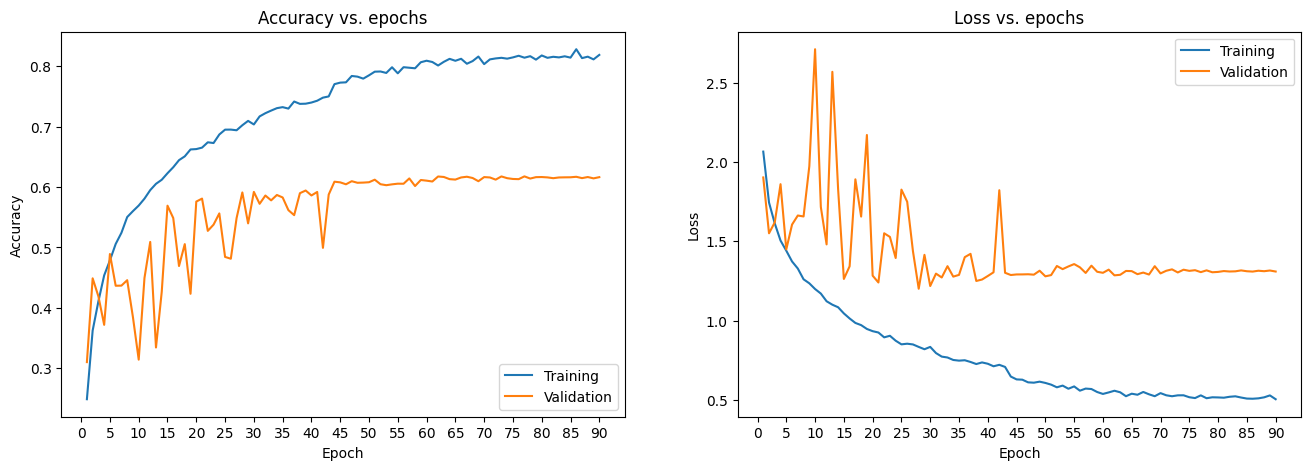

2022-08-16 08:34:33,770: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 2ms/step


2022-08-16 08:34:38,673: INFO: test loss:1.3058
2022-08-16 08:34:38,673: INFO: test accuracy:0.6176
2022-08-16 08:34:38,675: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/results.json
2022-08-16 08:34:38,676: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/results.json
2022-08-16 08:34:38,677: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/default.generator
2022-08-16 08:34:38,678: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/default.generator
2022-08-16 08:34:38,679: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-16 08:34:38,990: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/default.generator


313/313 [==============================] - 1s 1ms/step


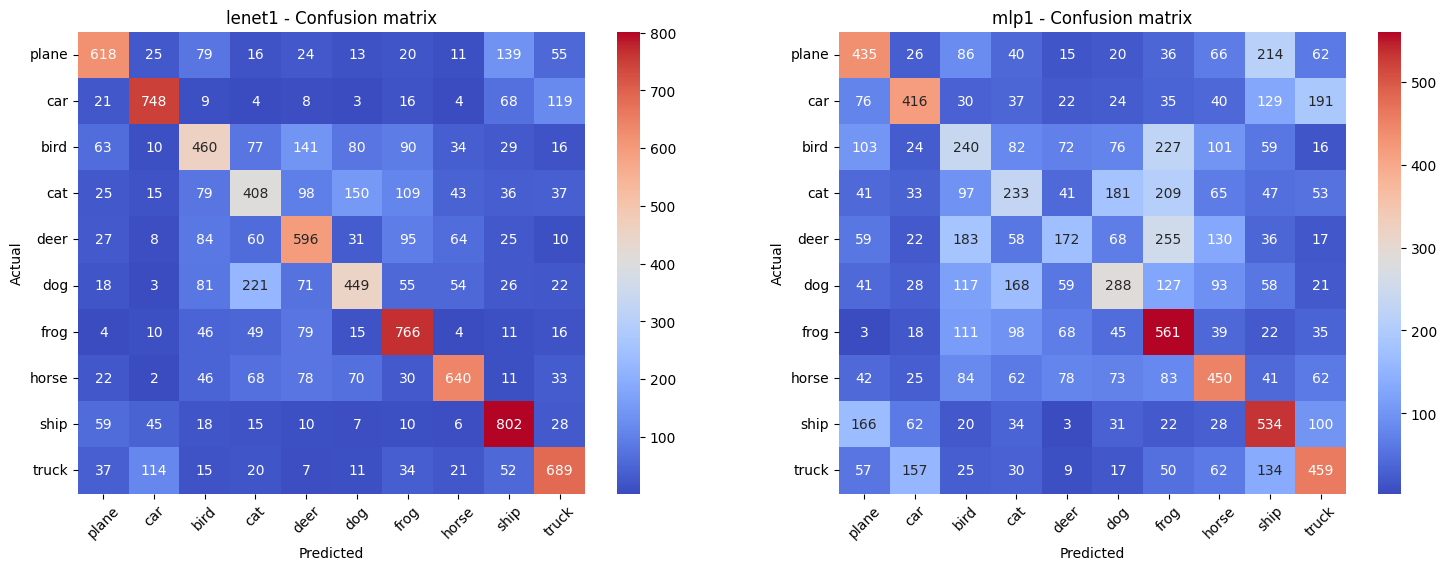

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  train_time  \
1     lenet1  cifar10_0816_cnt_1000.ipynb          83170       209.3   
2       mlp1  cifar10_0816_cnt_1000.ipynb         394634       120.8   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-16 08:34      0.1788     1.3058          0.9571         0.6176   
2  2022-08-16 08:31      1.5023     1.7401          0.4654         0.3788   

   train_auc  test_auc  
1     0.9988    0.9271  
2     0.8662    0.8141

In [24]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Custom 1


2022-08-16 08:34:42,166: INFO: model_params.custom1.dropout=0.2
2022-08-16 08:34:42,266: INFO: learning_rate=0.001
2022-08-16 08:34:42,267: INFO: model_params.custom1.clip_value=None
2022-08-16 08:34:42,274: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1


Model: "custom1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 16, 16, 32)        0   

2022-08-16 08:34:42,308: INFO: model_params.custom1.epochs=90
2022-08-16 08:34:42,308: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1, monitor=val_accuracy)
2022-08-16 08:34:42,309: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-16 08:34:42,310: INFO: use LearningRateScheduler()
2022-08-16 08:34:42,310: INFO: steps_per_epoch=312
2022-08-16 08:34:42,311: INFO: start training
2022-08-16 08:34:42,311: INFO: use_class_weight=False


Epoch 1/90
311/312 [============================>.] - ETA: 0s - loss: 1.9664 - accuracy: 0.2949

2022-08-16 08:34:47,324: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


2022-08-16 08:34:47,952: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


312/312 [==============================] - 6s 15ms/step - loss: 1.9648 - accuracy: 0.2958 - val_loss: 5.1697 - val_accuracy: 0.1269 - lr: 0.0010
Epoch 2/90
310/312 [============================>.] - ETA: 0s - loss: 1.6155 - accuracy: 0.4058

2022-08-16 08:34:51,472: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


2022-08-16 08:34:52,132: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


312/312 [==============================] - 4s 13ms/step - loss: 1.6154 - accuracy: 0.4055 - val_loss: 2.1276 - val_accuracy: 0.3043 - lr: 0.0010
Epoch 3/90
312/312 [==============================] - 2s 7ms/step - loss: 1.4766 - accuracy: 0.4695 - val_loss: 2.8975 - val_accuracy: 0.2597 - lr: 0.0010
Epoch 4/90
309/312 [============================>.] - ETA: 0s - loss: 1.3896 - accuracy: 0.4978

2022-08-16 08:34:58,060: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


2022-08-16 08:34:58,704: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


312/312 [==============================] - 4s 14ms/step - loss: 1.3889 - accuracy: 0.4982 - val_loss: 1.7352 - val_accuracy: 0.4321 - lr: 0.0010
Epoch 5/90
310/312 [============================>.] - ETA: 0s - loss: 1.2958 - accuracy: 0.5327

2022-08-16 08:35:02,309: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


2022-08-16 08:35:02,971: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


312/312 [==============================] - 4s 14ms/step - loss: 1.2947 - accuracy: 0.5333 - val_loss: 1.7215 - val_accuracy: 0.4539 - lr: 0.0010
Epoch 6/90
312/312 [==============================] - 2s 7ms/step - loss: 1.2417 - accuracy: 0.5536 - val_loss: 1.8803 - val_accuracy: 0.4068 - lr: 0.0010
Epoch 7/90
312/312 [==============================] - 2s 7ms/step - loss: 1.1911 - accuracy: 0.5759 - val_loss: 2.0879 - val_accuracy: 0.4060 - lr: 0.0010
Epoch 8/90
303/312 [============================>.] - ETA: 0s - loss: 1.1456 - accuracy: 0.5867

2022-08-16 08:35:10,853: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


2022-08-16 08:35:11,512: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


312/312 [==============================] - 4s 14ms/step - loss: 1.1449 - accuracy: 0.5873 - val_loss: 1.2661 - val_accuracy: 0.5620 - lr: 0.0010
Epoch 9/90
309/312 [============================>.] - ETA: 0s - loss: 1.1008 - accuracy: 0.6050

2022-08-16 08:35:15,393: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


2022-08-16 08:35:16,043: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


312/312 [==============================] - 5s 15ms/step - loss: 1.0995 - accuracy: 0.6056 - val_loss: 1.2801 - val_accuracy: 0.5622 - lr: 0.0010
Epoch 10/90
312/312 [==============================] - 2s 7ms/step - loss: 1.0573 - accuracy: 0.6225 - val_loss: 1.5822 - val_accuracy: 0.4746 - lr: 0.0010
Epoch 11/90
312/312 [==============================] - 2s 7ms/step - loss: 1.0253 - accuracy: 0.6270 - val_loss: 1.7611 - val_accuracy: 0.4516 - lr: 0.0010
Epoch 12/90
312/312 [==============================] - 2s 7ms/step - loss: 0.9968 - accuracy: 0.6411 - val_loss: 1.4277 - val_accuracy: 0.5343 - lr: 0.0010
Epoch 13/90
305/312 [============================>.] - ETA: 0s - loss: 0.9670 - accuracy: 0.6510

2022-08-16 08:35:26,288: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


2022-08-16 08:35:26,916: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


312/312 [==============================] - 4s 14ms/step - loss: 0.9681 - accuracy: 0.6508 - val_loss: 1.2233 - val_accuracy: 0.5924 - lr: 0.0010
Epoch 14/90
312/312 [==============================] - 2s 7ms/step - loss: 0.9394 - accuracy: 0.6643 - val_loss: 1.4204 - val_accuracy: 0.5480 - lr: 0.0010
Epoch 15/90
312/312 [==============================] - 2s 7ms/step - loss: 0.9078 - accuracy: 0.6773 - val_loss: 1.4307 - val_accuracy: 0.5416 - lr: 0.0010
Epoch 16/90
309/312 [============================>.] - ETA: 0s - loss: 0.8816 - accuracy: 0.6836

2022-08-16 08:35:34,792: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


2022-08-16 08:35:35,670: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


312/312 [==============================] - 4s 14ms/step - loss: 0.8810 - accuracy: 0.6837 - val_loss: 1.1193 - val_accuracy: 0.6267 - lr: 0.0010
Epoch 17/90
312/312 [==============================] - 2s 7ms/step - loss: 0.8761 - accuracy: 0.6873 - val_loss: 1.4260 - val_accuracy: 0.5524 - lr: 0.0010
Epoch 18/90
312/312 [==============================] - 2s 7ms/step - loss: 0.8562 - accuracy: 0.6935 - val_loss: 1.1008 - val_accuracy: 0.6137 - lr: 0.0010
Epoch 19/90
312/312 [==============================] - 2s 7ms/step - loss: 0.8386 - accuracy: 0.7045 - val_loss: 1.2620 - val_accuracy: 0.5804 - lr: 0.0010
Epoch 20/90
312/312 [==============================] - 2s 7ms/step - loss: 0.8281 - accuracy: 0.7044 - val_loss: 1.1370 - val_accuracy: 0.6116 - lr: 0.0010
Epoch 21/90
312/312 [==============================] - 2s 7ms/step - loss: 0.8061 - accuracy: 0.7102 - val_loss: 1.2907 - val_accuracy: 0.5874 - lr: 0.0010
Epoch 22/90
312/312 [==============================] - 2s 7ms/step - loss: 

2022-08-16 08:35:52,380: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


2022-08-16 08:35:53,038: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


312/312 [==============================] - 4s 14ms/step - loss: 0.7821 - accuracy: 0.7233 - val_loss: 1.0844 - val_accuracy: 0.6325 - lr: 0.0010
Epoch 24/90
312/312 [==============================] - 2s 7ms/step - loss: 0.7675 - accuracy: 0.7220 - val_loss: 1.3833 - val_accuracy: 0.5539 - lr: 0.0010
Epoch 25/90
310/312 [============================>.] - ETA: 0s - loss: 0.7575 - accuracy: 0.7275

2022-08-16 08:35:58,977: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


2022-08-16 08:35:59,633: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


312/312 [==============================] - 4s 14ms/step - loss: 0.7565 - accuracy: 0.7279 - val_loss: 1.0583 - val_accuracy: 0.6459 - lr: 0.0010
Epoch 26/90
312/312 [==============================] - 2s 7ms/step - loss: 0.7394 - accuracy: 0.7366 - val_loss: 1.1614 - val_accuracy: 0.6225 - lr: 0.0010
Epoch 27/90
312/312 [==============================] - 2s 7ms/step - loss: 0.7333 - accuracy: 0.7301 - val_loss: 1.0920 - val_accuracy: 0.6419 - lr: 0.0010
Epoch 28/90
312/312 [==============================] - 2s 7ms/step - loss: 0.7203 - accuracy: 0.7408 - val_loss: 1.2172 - val_accuracy: 0.6139 - lr: 0.0010
Epoch 29/90
312/312 [==============================] - 2s 7ms/step - loss: 0.7169 - accuracy: 0.7436 - val_loss: 1.1394 - val_accuracy: 0.6375 - lr: 0.0010
Epoch 30/90
312/312 [==============================] - 2s 7ms/step - loss: 0.6997 - accuracy: 0.7453 - val_loss: 1.2184 - val_accuracy: 0.6143 - lr: 0.0010
Epoch 31/90
312/312 [==============================] - 2s 7ms/step - loss: 

2022-08-16 08:36:27,320: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


2022-08-16 08:36:27,954: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


312/312 [==============================] - 4s 14ms/step - loss: 0.6540 - accuracy: 0.7624 - val_loss: 1.0895 - val_accuracy: 0.6555 - lr: 0.0010
Epoch 38/90
312/312 [==============================] - 2s 7ms/step - loss: 0.6382 - accuracy: 0.7670 - val_loss: 1.1164 - val_accuracy: 0.6460 - lr: 0.0010
Epoch 39/90
312/312 [==============================] - 2s 7ms/step - loss: 0.6351 - accuracy: 0.7698 - val_loss: 1.3277 - val_accuracy: 0.6035 - lr: 0.0010
Epoch 40/90
304/312 [============================>.] - ETA: 0s - loss: 0.6337 - accuracy: 0.7687
Epoch 40: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
312/312 [==============================] - 2s 7ms/step - loss: 0.6346 - accuracy: 0.7684 - val_loss: 1.1967 - val_accuracy: 0.6378 - lr: 3.1623e-04
Epoch 00041: Still keep learning rate 0.0003162 instead of 0.001
Epoch 41/90
311/312 [============================>.] - ETA: 0s - loss: 0.5646 - accuracy: 0.7976

2022-08-16 08:36:38,053: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


2022-08-16 08:36:38,685: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


312/312 [==============================] - 4s 13ms/step - loss: 0.5644 - accuracy: 0.7978 - val_loss: 1.1271 - val_accuracy: 0.6575 - lr: 3.1623e-04
Epoch 00042: Still keep learning rate 0.0003162 instead of 0.001
Epoch 42/90
308/312 [============================>.] - ETA: 0s - loss: 0.5446 - accuracy: 0.7990

2022-08-16 08:36:42,277: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


2022-08-16 08:36:42,923: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


312/312 [==============================] - 4s 14ms/step - loss: 0.5442 - accuracy: 0.7988 - val_loss: 1.0674 - val_accuracy: 0.6737 - lr: 3.1623e-04
Epoch 00043: Still keep learning rate 0.0003162 instead of 0.001
Epoch 43/90
312/312 [==============================] - 2s 7ms/step - loss: 0.5429 - accuracy: 0.8048 - val_loss: 1.0629 - val_accuracy: 0.6722 - lr: 3.1623e-04
Epoch 00044: Still keep learning rate 0.0003162 instead of 0.001
Epoch 44/90
312/312 [==============================] - 2s 7ms/step - loss: 0.5324 - accuracy: 0.8052 - val_loss: 1.0965 - val_accuracy: 0.6666 - lr: 3.1623e-04
Epoch 00045: Still keep learning rate 0.0003162 instead of 0.001
Epoch 45/90
312/312 [==============================] - 2s 7ms/step - loss: 0.5112 - accuracy: 0.8151 - val_loss: 1.1143 - val_accuracy: 0.6650 - lr: 3.1623e-04
Epoch 00046: Still keep learning rate 0.0003162 instead of 0.001
Epoch 46/90
312/312 [==============================] - 2s 7ms/step - loss: 0.5216 - accuracy: 0.8118 - val_loss

2022-08-16 08:37:23,553: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


2022-08-16 08:37:24,219: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


312/312 [==============================] - 5s 14ms/step - loss: 0.4470 - accuracy: 0.8413 - val_loss: 1.0910 - val_accuracy: 0.6738 - lr: 1.0000e-04
Epoch 61/90
309/312 [============================>.] - ETA: 0s - loss: 0.4527 - accuracy: 0.8377

2022-08-16 08:37:27,800: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


2022-08-16 08:37:28,444: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


312/312 [==============================] - 4s 14ms/step - loss: 0.4536 - accuracy: 0.8367 - val_loss: 1.0988 - val_accuracy: 0.6745 - lr: 1.0000e-04
Epoch 62/90
309/312 [============================>.] - ETA: 0s - loss: 0.4607 - accuracy: 0.8331

2022-08-16 08:37:32,003: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


2022-08-16 08:37:32,648: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


312/312 [==============================] - 4s 13ms/step - loss: 0.4595 - accuracy: 0.8338 - val_loss: 1.0911 - val_accuracy: 0.6766 - lr: 1.0000e-04
Epoch 63/90
312/312 [==============================] - 2s 7ms/step - loss: 0.4523 - accuracy: 0.8391 - val_loss: 1.1165 - val_accuracy: 0.6739 - lr: 1.0000e-04
Epoch 64/90
312/312 [==============================] - 2s 7ms/step - loss: 0.4391 - accuracy: 0.8435 - val_loss: 1.1223 - val_accuracy: 0.6730 - lr: 1.0000e-04
Epoch 65/90
312/312 [==============================] - 2s 7ms/step - loss: 0.4377 - accuracy: 0.8419 - val_loss: 1.1067 - val_accuracy: 0.6755 - lr: 1.0000e-04
Epoch 66/90
312/312 [==============================] - 2s 7ms/step - loss: 0.4421 - accuracy: 0.8376 - val_loss: 1.1151 - val_accuracy: 0.6743 - lr: 1.0000e-04
Epoch 67/90
312/312 [==============================] - 2s 7ms/step - loss: 0.4458 - accuracy: 0.8373 - val_loss: 1.1179 - val_accuracy: 0.6737 - lr: 1.0000e-04
Epoch 68/90
312/312 [==============================

2022-08-16 08:37:51,596: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


2022-08-16 08:37:52,232: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets



Epoch 70: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
312/312 [==============================] - 4s 14ms/step - loss: 0.4369 - accuracy: 0.8411 - val_loss: 1.1180 - val_accuracy: 0.6771 - lr: 3.1623e-05
Epoch 00071: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 71/90
301/312 [===========================>..] - ETA: 0s - loss: 0.4258 - accuracy: 0.8440

2022-08-16 08:37:55,743: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


2022-08-16 08:37:56,404: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


312/312 [==============================] - 4s 13ms/step - loss: 0.4259 - accuracy: 0.8442 - val_loss: 1.0897 - val_accuracy: 0.6799 - lr: 3.1623e-05
Epoch 00072: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 72/90
312/312 [==============================] - 2s 7ms/step - loss: 0.4302 - accuracy: 0.8427 - val_loss: 1.0946 - val_accuracy: 0.6791 - lr: 3.1623e-05
Epoch 00073: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 73/90
309/312 [============================>.] - ETA: 0s - loss: 0.4273 - accuracy: 0.8423

2022-08-16 08:38:02,333: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


2022-08-16 08:38:03,241: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


312/312 [==============================] - 5s 15ms/step - loss: 0.4274 - accuracy: 0.8423 - val_loss: 1.0946 - val_accuracy: 0.6813 - lr: 3.1623e-05
Epoch 00074: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 74/90
312/312 [==============================] - 2s 7ms/step - loss: 0.4316 - accuracy: 0.8370 - val_loss: 1.1100 - val_accuracy: 0.6784 - lr: 3.1623e-05
Epoch 00075: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 75/90
312/312 [==============================] - 2s 7ms/step - loss: 0.4310 - accuracy: 0.8460 - val_loss: 1.0984 - val_accuracy: 0.6803 - lr: 3.1623e-05
Epoch 00076: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 76/90
312/312 [==============================] - 2s 7ms/step - loss: 0.4290 - accuracy: 0.8435 - val_loss: 1.1123 - val_accuracy: 0.6790 - lr: 3.1623e-05
Epoch 00077: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 77/90
312/312 [==============================] - 2s 7ms/step - loss: 0.4327 - accuracy: 0.8451 - val_loss

2022-08-16 08:38:26,345: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


2022-08-16 08:38:27,010: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


312/312 [==============================] - 4s 14ms/step - loss: 0.4187 - accuracy: 0.8480 - val_loss: 1.1122 - val_accuracy: 0.6825 - lr: 3.1623e-05
Epoch 00084: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 84/90
312/312 [==============================] - 2s 7ms/step - loss: 0.4246 - accuracy: 0.8484 - val_loss: 1.1070 - val_accuracy: 0.6793 - lr: 3.1623e-05
Epoch 00085: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 85/90
306/312 [============================>.] - ETA: 0s - loss: 0.4293 - accuracy: 0.8431

2022-08-16 08:38:32,834: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


2022-08-16 08:38:33,471: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets



Epoch 85: ReduceLROnPlateau reducing learning rate to 9.999999259090306e-06.
312/312 [==============================] - 4s 14ms/step - loss: 0.4290 - accuracy: 0.8432 - val_loss: 1.0927 - val_accuracy: 0.6826 - lr: 1.0000e-05
Epoch 00086: Still keep learning rate 1e-05 instead of 0.0001
Epoch 86/90
311/312 [============================>.] - ETA: 0s - loss: 0.4195 - accuracy: 0.8532

2022-08-16 08:38:37,311: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


2022-08-16 08:38:37,992: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


312/312 [==============================] - 5s 15ms/step - loss: 0.4194 - accuracy: 0.8533 - val_loss: 1.1014 - val_accuracy: 0.6839 - lr: 1.0000e-05
Epoch 00087: Still keep learning rate 1e-05 instead of 0.0001
Epoch 87/90
312/312 [==============================] - 2s 7ms/step - loss: 0.4325 - accuracy: 0.8439 - val_loss: 1.1058 - val_accuracy: 0.6830 - lr: 1.0000e-05
Epoch 00088: Still keep learning rate 1e-05 instead of 0.0001
Epoch 88/90
312/312 [==============================] - 2s 8ms/step - loss: 0.4159 - accuracy: 0.8540 - val_loss: 1.1041 - val_accuracy: 0.6831 - lr: 1.0000e-05
Epoch 00089: Still keep learning rate 1e-05 instead of 0.0001
Epoch 89/90
312/312 [==============================] - 2s 7ms/step - loss: 0.4178 - accuracy: 0.8491 - val_loss: 1.1006 - val_accuracy: 0.6829 - lr: 1.0000e-05
Epoch 00090: Still keep learning rate 1e-05 instead of 0.0001
Epoch 90/90
309/312 [============================>.] - ETA: 0s - loss: 0.4345 - accuracy: 0.8464

2022-08-16 08:38:48,281: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


2022-08-16 08:38:48,946: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1/assets


312/312 [==============================] - 4s 14ms/step - loss: 0.4339 - accuracy: 0.8468 - val_loss: 1.0998 - val_accuracy: 0.6844 - lr: 1.0000e-05


2022-08-16 08:38:49,019: INFO: finish training [elapsed time: 246.71 seconds]


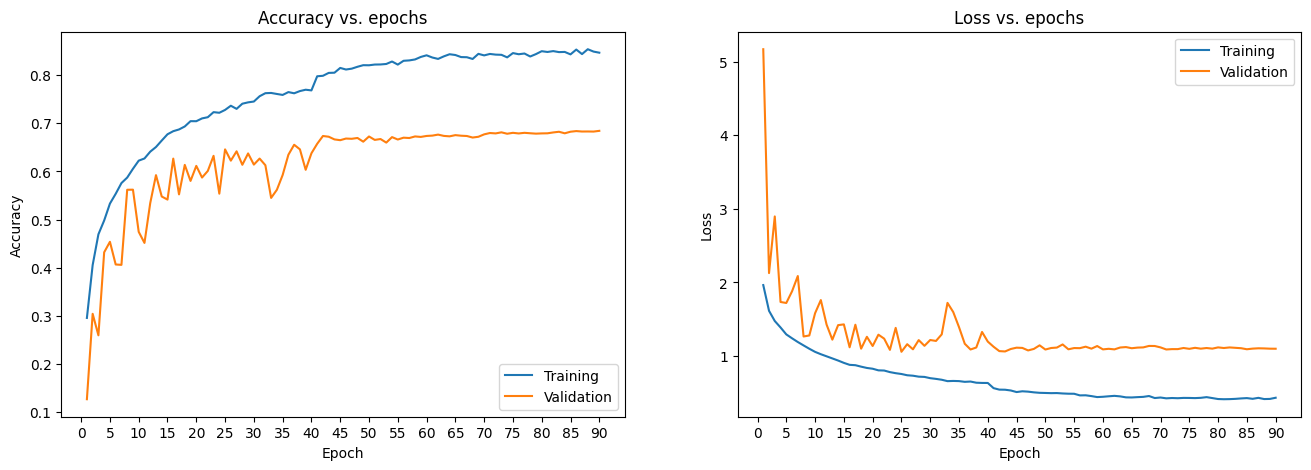

2022-08-16 08:38:49,417: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 2ms/step


2022-08-16 08:38:54,982: INFO: test loss:1.0998
2022-08-16 08:38:54,982: INFO: test accuracy:0.6844
2022-08-16 08:38:54,984: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/results.json


----------------------------------------save model results and generator----------------------------------------


2022-08-16 08:38:54,986: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/results.json
2022-08-16 08:38:54,986: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/default.generator
2022-08-16 08:38:54,987: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/default.generator
2022-08-16 08:38:54,988: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1


----------------------------------------confusion matrix----------------------------------------


2022-08-16 08:38:56,097: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/default.generator


313/313 [==============================] - 1s 2ms/step


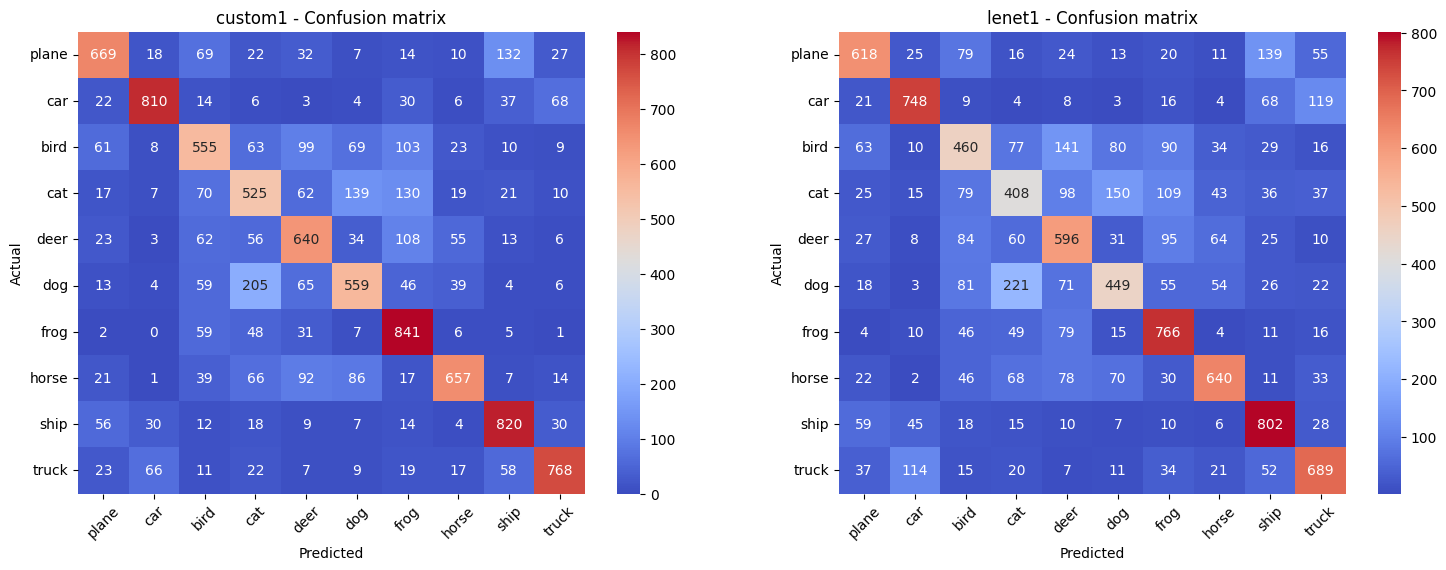

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  train_time  \
1    custom1  cifar10_0816_cnt_1000.ipynb          73738       246.7   
2     lenet1  cifar10_0816_cnt_1000.ipynb          83170       209.3   
3       mlp1  cifar10_0816_cnt_1000.ipynb         394634       120.8   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-16 08:38      0.1393     1.0998          0.9655         0.6844   
2  2022-08-16 08:34      0.1788     1.3058          0.9571         0.6176   
3  2022-08-16 08:31      1.5023     1.7401          0.4654         0.3788   

   train_auc  test_auc  
1     0.9991    0.9487  
2     0.9988    0.9271  
3     0.8662    0.8141

In [25]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### VGG

In [26]:
rescale1 = tf.keras.layers.Rescaling(1./255.0)
for data, label in datasets.train_dataset.take(1):
    print(data[0][0][0:5]) 
    print(rescale(data)[0][0][0:5])  

tf.Tensor(
[[51 34 11]
 [51 35  9]
 [58 41 12]
 [71 58 19]
 [99 87 37]], shape=(5, 3), dtype=uint8)
tf.Tensor(
[[0.20000002 0.13333334 0.04313726]
 [0.20000002 0.13725491 0.03529412]
 [0.227451   0.16078432 0.04705883]
 [0.2784314  0.227451   0.07450981]
 [0.38823533 0.34117648 0.14509805]], shape=(5, 3), dtype=float32)


In [27]:

helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3, 
                                             preprocess_fun=rescale)
model.summary()


2022-08-16 08:38:59,722: INFO: model_params.vgg8.dropout=0.1
2022-08-16 08:38:59,885: INFO: learning_rate=0.001
2022-08-16 08:38:59,886: INFO: model_params.vgg8.clip_value=None
2022-08-16 08:38:59,892: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8


Model: "vgg8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 block1_con1 (Conv2D)        (None, 32, 32, 64)        1792      
                                                                 
 block1_bn1 (BatchNormalizat  (None, 32, 32, 64)       256       
 ion)                                                            
                                                                 
 block1_relu1 (ReLU)         (None, 32, 32, 64)        0         
                                                                 
 block1_con2 (Conv2D)        (None, 32, 32, 64)        36928     
                                                              

2022-08-16 08:39:00,033: INFO: model_params.vgg8.epochs=90
2022-08-16 08:39:00,034: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8, monitor=val_accuracy)
2022-08-16 08:39:00,035: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-16 08:39:00,036: INFO: use LearningRateScheduler()
2022-08-16 08:39:00,036: INFO: steps_per_epoch=312
2022-08-16 08:39:00,037: INFO: start training
2022-08-16 08:39:00,038: INFO: use_class_weight=False


Epoch 1/90
311/312 [============================>.] - ETA: 0s - loss: 2.1677 - accuracy: 0.2223

2022-08-16 08:39:08,388: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8/assets


2022-08-16 08:39:09,739: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8/assets


312/312 [==============================] - 10s 27ms/step - loss: 2.1665 - accuracy: 0.2223 - val_loss: 2.8996 - val_accuracy: 0.1024 - lr: 0.0010
Epoch 2/90
312/312 [==============================] - ETA: 0s - loss: 1.7187 - accuracy: 0.3412

2022-08-16 08:39:16,236: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8/assets


2022-08-16 08:39:17,280: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8/assets


312/312 [==============================] - 8s 24ms/step - loss: 1.7187 - accuracy: 0.3412 - val_loss: 1.9211 - val_accuracy: 0.3067 - lr: 0.0010
Epoch 3/90
312/312 [==============================] - ETA: 0s - loss: 1.5220 - accuracy: 0.4328

2022-08-16 08:39:23,762: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8/assets


2022-08-16 08:39:25,153: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8/assets


312/312 [==============================] - 8s 25ms/step - loss: 1.5220 - accuracy: 0.4328 - val_loss: 1.3873 - val_accuracy: 0.4946 - lr: 0.0010
Epoch 4/90
312/312 [==============================] - 4s 13ms/step - loss: 1.3522 - accuracy: 0.4971 - val_loss: 1.4210 - val_accuracy: 0.4871 - lr: 0.0010
Epoch 5/90
312/312 [==============================] - 4s 14ms/step - loss: 1.2357 - accuracy: 0.5367 - val_loss: 2.2850 - val_accuracy: 0.3269 - lr: 0.0010
Epoch 6/90
312/312 [==============================] - ETA: 0s - loss: 1.1393 - accuracy: 0.5740

2022-08-16 08:39:40,080: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8/assets


2022-08-16 08:39:41,147: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8/assets


312/312 [==============================] - 8s 24ms/step - loss: 1.1393 - accuracy: 0.5740 - val_loss: 1.3373 - val_accuracy: 0.5315 - lr: 0.0010
Epoch 7/90
312/312 [==============================] - 4s 14ms/step - loss: 1.0642 - accuracy: 0.6009 - val_loss: 1.6019 - val_accuracy: 0.4922 - lr: 0.0010
Epoch 8/90
312/312 [==============================] - 4s 13ms/step - loss: 0.9900 - accuracy: 0.6262 - val_loss: 1.7067 - val_accuracy: 0.4582 - lr: 0.0010
Epoch 9/90
312/312 [==============================] - 4s 14ms/step - loss: 0.9211 - accuracy: 0.6474 - val_loss: 2.2616 - val_accuracy: 0.4148 - lr: 0.0010
Epoch 10/90
312/312 [==============================] - 4s 14ms/step - loss: 0.8658 - accuracy: 0.6786 - val_loss: 1.8868 - val_accuracy: 0.4542 - lr: 0.0010
Epoch 11/90
312/312 [==============================] - 4s 14ms/step - loss: 0.8146 - accuracy: 0.6926 - val_loss: 1.6953 - val_accuracy: 0.4902 - lr: 0.0010
Epoch 12/90
308/312 [============================>.] - ETA: 0s - loss: 0.

2022-08-16 08:40:09,137: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8/assets


2022-08-16 08:40:10,208: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8/assets


312/312 [==============================] - 8s 25ms/step - loss: 0.7408 - accuracy: 0.7143 - val_loss: 1.0702 - val_accuracy: 0.6538 - lr: 0.0010
Epoch 13/90
312/312 [==============================] - 4s 14ms/step - loss: 0.6887 - accuracy: 0.7336 - val_loss: 1.7490 - val_accuracy: 0.5323 - lr: 0.0010
Epoch 14/90
312/312 [==============================] - 4s 13ms/step - loss: 0.6473 - accuracy: 0.7489 - val_loss: 1.5194 - val_accuracy: 0.5786 - lr: 0.0010
Epoch 15/90
312/312 [==============================] - 4s 14ms/step - loss: 0.6132 - accuracy: 0.7640 - val_loss: 1.3104 - val_accuracy: 0.6332 - lr: 0.0010
Epoch 16/90
312/312 [==============================] - 4s 14ms/step - loss: 0.5672 - accuracy: 0.7841 - val_loss: 1.1702 - val_accuracy: 0.6510 - lr: 0.0010
Epoch 17/90
312/312 [==============================] - 4s 13ms/step - loss: 0.5396 - accuracy: 0.7953 - val_loss: 2.4057 - val_accuracy: 0.5537 - lr: 0.0010
Epoch 18/90
312/312 [==============================] - 4s 14ms/step - 

2022-08-16 08:40:46,301: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8/assets


2022-08-16 08:40:47,346: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8/assets


312/312 [==============================] - 8s 24ms/step - loss: 0.4396 - accuracy: 0.8318 - val_loss: 1.5010 - val_accuracy: 0.6539 - lr: 0.0010
Epoch 21/90
312/312 [==============================] - 4s 14ms/step - loss: 0.4067 - accuracy: 0.8474 - val_loss: 1.6569 - val_accuracy: 0.6365 - lr: 0.0010
Epoch 22/90
307/312 [============================>.] - ETA: 0s - loss: 0.4044 - accuracy: 0.8497

2022-08-16 08:40:58,335: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8/assets


2022-08-16 08:40:59,448: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8/assets


312/312 [==============================] - 8s 25ms/step - loss: 0.4034 - accuracy: 0.8496 - val_loss: 1.2641 - val_accuracy: 0.6894 - lr: 0.0010
Epoch 23/90
312/312 [==============================] - 4s 14ms/step - loss: 0.3762 - accuracy: 0.8596 - val_loss: 1.3862 - val_accuracy: 0.6784 - lr: 0.0010
Epoch 24/90
312/312 [==============================] - 4s 14ms/step - loss: 0.3624 - accuracy: 0.8608 - val_loss: 1.9633 - val_accuracy: 0.6202 - lr: 0.0010
Epoch 25/90
312/312 [==============================] - 4s 14ms/step - loss: 0.3703 - accuracy: 0.8592 - val_loss: 1.8632 - val_accuracy: 0.6536 - lr: 0.0010
Epoch 26/90
312/312 [==============================] - 4s 14ms/step - loss: 0.3419 - accuracy: 0.8738 - val_loss: 1.3822 - val_accuracy: 0.6890 - lr: 0.0010
Epoch 27/90
309/312 [============================>.] - ETA: 0s - loss: 0.3278 - accuracy: 0.8770

2022-08-16 08:41:22,855: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8/assets


2022-08-16 08:41:23,922: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8/assets



Epoch 27: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
312/312 [==============================] - 8s 24ms/step - loss: 0.3279 - accuracy: 0.8770 - val_loss: 1.3618 - val_accuracy: 0.7075 - lr: 3.1623e-04
Epoch 00028: Still keep learning rate 0.0003162 instead of 0.001
Epoch 28/90
308/312 [============================>.] - ETA: 0s - loss: 0.2651 - accuracy: 0.9015

2022-08-16 08:41:30,747: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8/assets


2022-08-16 08:41:31,805: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8/assets


312/312 [==============================] - 8s 25ms/step - loss: 0.2642 - accuracy: 0.9019 - val_loss: 1.1879 - val_accuracy: 0.7290 - lr: 3.1623e-04
Epoch 00029: Still keep learning rate 0.0003162 instead of 0.001
Epoch 29/90
308/312 [============================>.] - ETA: 0s - loss: 0.2408 - accuracy: 0.9108

2022-08-16 08:41:38,475: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8/assets


2022-08-16 08:41:39,551: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8/assets


312/312 [==============================] - 8s 26ms/step - loss: 0.2407 - accuracy: 0.9112 - val_loss: 1.2229 - val_accuracy: 0.7318 - lr: 3.1623e-04
Epoch 00030: Still keep learning rate 0.0003162 instead of 0.001
Epoch 30/90
310/312 [============================>.] - ETA: 0s - loss: 0.2296 - accuracy: 0.9156

2022-08-16 08:41:46,308: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8/assets


2022-08-16 08:41:47,380: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8/assets


312/312 [==============================] - 8s 24ms/step - loss: 0.2298 - accuracy: 0.9156 - val_loss: 1.2676 - val_accuracy: 0.7339 - lr: 3.1623e-04
Epoch 00031: Still keep learning rate 0.0003162 instead of 0.001
Epoch 31/90
312/312 [==============================] - 4s 14ms/step - loss: 0.2196 - accuracy: 0.9171 - val_loss: 1.2564 - val_accuracy: 0.7319 - lr: 3.1623e-04
Epoch 00032: Still keep learning rate 0.0003162 instead of 0.001
Epoch 32/90
312/312 [==============================] - ETA: 0s - loss: 0.2096 - accuracy: 0.9210

2022-08-16 08:41:58,228: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8/assets


2022-08-16 08:41:59,646: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8/assets


312/312 [==============================] - 8s 26ms/step - loss: 0.2096 - accuracy: 0.9210 - val_loss: 1.2016 - val_accuracy: 0.7428 - lr: 3.1623e-04
Epoch 00033: Still keep learning rate 0.0003162 instead of 0.001
Epoch 33/90
312/312 [==============================] - 4s 14ms/step - loss: 0.2173 - accuracy: 0.9186 - val_loss: 1.3270 - val_accuracy: 0.7339 - lr: 3.1623e-04
Epoch 00034: Still keep learning rate 0.0003162 instead of 0.001
Epoch 34/90
312/312 [==============================] - 4s 14ms/step - loss: 0.2034 - accuracy: 0.9236 - val_loss: 1.4913 - val_accuracy: 0.7158 - lr: 3.1623e-04
Epoch 00035: Still keep learning rate 0.0003162 instead of 0.001
Epoch 35/90
312/312 [==============================] - 4s 14ms/step - loss: 0.2052 - accuracy: 0.9237 - val_loss: 1.2924 - val_accuracy: 0.7342 - lr: 3.1623e-04
Epoch 00036: Still keep learning rate 0.0003162 instead of 0.001
Epoch 36/90
312/312 [==============================] - 4s 13ms/step - loss: 0.2133 - accuracy: 0.9180 - val_

2022-08-16 08:42:48,463: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8/assets


2022-08-16 08:42:49,551: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8/assets


312/312 [==============================] - 8s 24ms/step - loss: 0.1711 - accuracy: 0.9366 - val_loss: 1.3948 - val_accuracy: 0.7505 - lr: 1.0000e-04
Epoch 00044: Still keep learning rate 0.0001 instead of 0.001
Epoch 44/90
312/312 [==============================] - 4s 13ms/step - loss: 0.1684 - accuracy: 0.9343 - val_loss: 1.4473 - val_accuracy: 0.7428 - lr: 1.0000e-04
Epoch 00045: Still keep learning rate 0.0001 instead of 0.001
Epoch 45/90
312/312 [==============================] - 4s 14ms/step - loss: 0.1665 - accuracy: 0.9359 - val_loss: 1.4220 - val_accuracy: 0.7409 - lr: 1.0000e-04
Epoch 00046: Still keep learning rate 0.0001 instead of 0.001
Epoch 46/90
310/312 [============================>.] - ETA: 0s - loss: 0.1769 - accuracy: 0.9323

2022-08-16 08:43:04,805: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8/assets


2022-08-16 08:43:05,902: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8/assets


312/312 [==============================] - 8s 25ms/step - loss: 0.1763 - accuracy: 0.9324 - val_loss: 1.3996 - val_accuracy: 0.7516 - lr: 1.0000e-04
Epoch 00047: Still keep learning rate 0.0001 instead of 0.001
Epoch 47/90
312/312 [==============================] - 4s 14ms/step - loss: 0.1807 - accuracy: 0.9314 - val_loss: 1.4486 - val_accuracy: 0.7447 - lr: 1.0000e-04
Epoch 00048: Still keep learning rate 0.0001 instead of 0.001
Epoch 48/90
312/312 [==============================] - 4s 14ms/step - loss: 0.1662 - accuracy: 0.9378 - val_loss: 1.4421 - val_accuracy: 0.7501 - lr: 1.0000e-04
Epoch 00049: Still keep learning rate 0.0001 instead of 0.001
Epoch 49/90
312/312 [==============================] - 4s 14ms/step - loss: 0.1618 - accuracy: 0.9363 - val_loss: 1.4860 - val_accuracy: 0.7490 - lr: 1.0000e-04
Epoch 00050: Still keep learning rate 0.0001 instead of 0.001
Epoch 50/90
312/312 [==============================] - 4s 14ms/step - loss: 0.1636 - accuracy: 0.9358 - val_loss: 1.5229

2022-08-16 08:45:15,369: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8/assets


2022-08-16 08:45:16,425: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8/assets


312/312 [==============================] - 8s 24ms/step - loss: 0.1616 - accuracy: 0.9368 - val_loss: 1.3588 - val_accuracy: 0.7527 - lr: 3.1623e-05
Epoch 00077: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 77/90
312/312 [==============================] - 4s 14ms/step - loss: 0.1653 - accuracy: 0.9370 - val_loss: 1.3739 - val_accuracy: 0.7511 - lr: 3.1623e-05
Epoch 00078: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 78/90
312/312 [==============================] - 4s 14ms/step - loss: 0.1641 - accuracy: 0.9358 - val_loss: 1.3795 - val_accuracy: 0.7504 - lr: 3.1623e-05
Epoch 00079: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 79/90
312/312 [==============================] - 4s 14ms/step - loss: 0.1673 - accuracy: 0.9373 - val_loss: 1.3634 - val_accuracy: 0.7511 - lr: 3.1623e-05
Epoch 00080: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 80/90
312/312 [==============================] - 4s 14ms/step - loss: 0.1622 - accuracy: 0.9390 - val_

2022-08-16 08:46:15,975: INFO: finish training [elapsed time: 435.94 seconds]


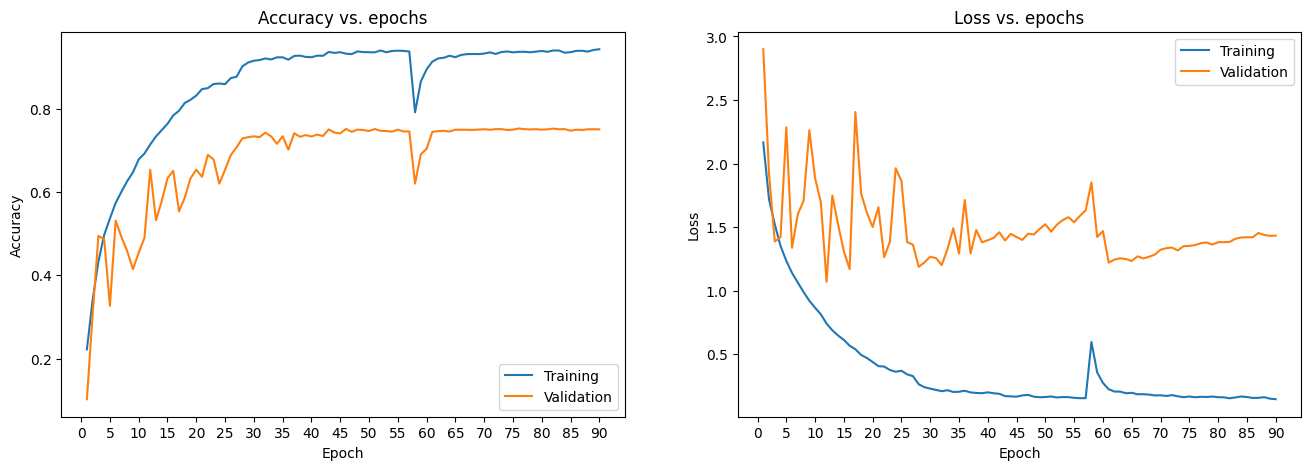

2022-08-16 08:46:16,370: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 3ms/step


2022-08-16 08:46:24,229: INFO: test loss:1.3588
2022-08-16 08:46:24,230: INFO: test accuracy:0.7527
2022-08-16 08:46:24,232: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/results.json


----------------------------------------save model results and generator----------------------------------------


2022-08-16 08:46:24,234: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/results.json
2022-08-16 08:46:24,234: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/default.generator
2022-08-16 08:46:24,236: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/default.generator
2022-08-16 08:46:24,237: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1


----------------------------------------confusion matrix----------------------------------------


2022-08-16 08:46:25,190: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/default.generator


313/313 [==============================] - 1s 2ms/step


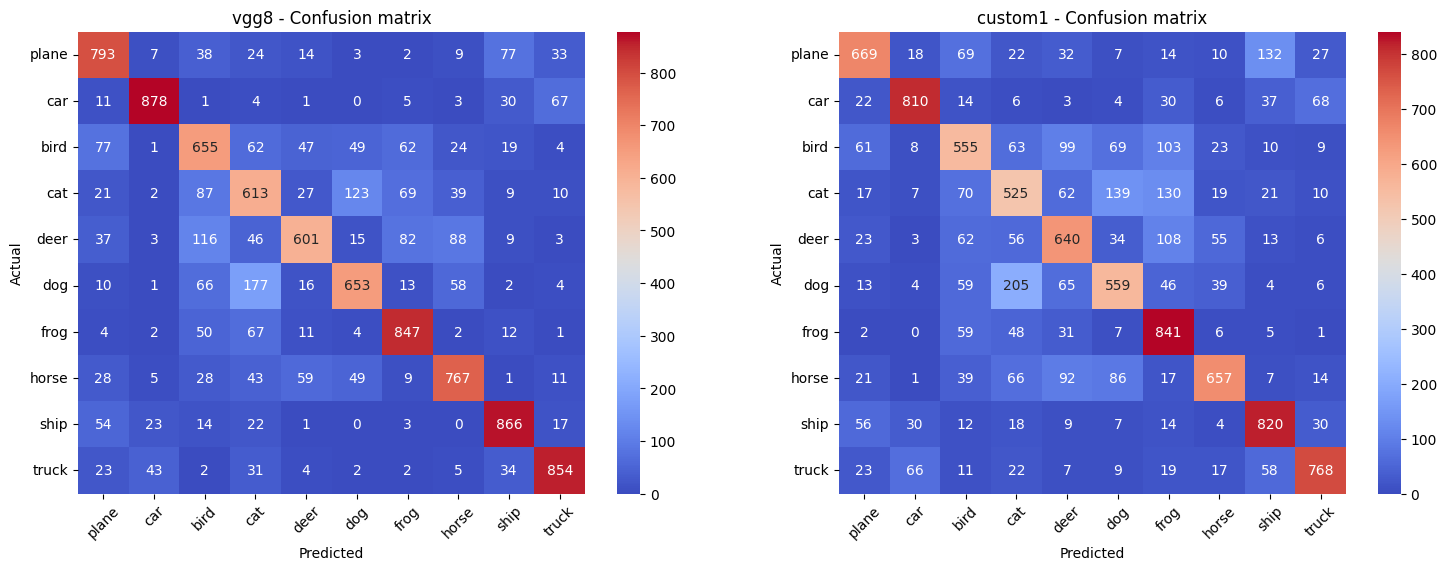

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  train_time  \
1       vgg8  cifar10_0816_cnt_1000.ipynb        1672906       435.9   
2    custom1  cifar10_0816_cnt_1000.ipynb          73738       246.7   
3     lenet1  cifar10_0816_cnt_1000.ipynb          83170       209.3   
4       mlp1  cifar10_0816_cnt_1000.ipynb         394634       120.8   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-16 08:46      0.0137     1.3588          0.9992         0.7527   
2  2022-08-16 08:38      0.1393     1.0998          0.9655         0.6844   
3  2022-08-16 08:34      0.1788     1.3058          0.9571         0.6176   
4  2022-08-16 08:31      1.5023     1.7401          0.4654         0.3788   

   train_auc  test_auc  
1     1.0000    0.9586  
2     0.9991    0.9487  
3     0.9988    0.9271  
4     0.8662    0.8141

In [28]:
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Resnet

see https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

2022-08-16 08:46:29,507: INFO: learning_rate=0.001
2022-08-16 08:46:29,508: INFO: model_params.resnet_v1_20.clip_value=None
2022-08-16 08:46:29,516: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20


Model: "resnet_v1_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 32, 32, 3)    0           ['input_5[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 32, 32, 16)   448         ['rescaling[4][0]']              
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 32, 32, 16)  64          ['conv2d_5[0][0]']               
 rmalization)                                                                          

                                                                                                  
 conv2d_15 (Conv2D)             (None, 16, 16, 32)   9248        ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_14 (BatchN  (None, 16, 16, 32)  128         ['conv2d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_9 (Activation)      (None, 16, 16, 32)   0           ['batch_normalization_14[0][0]'] 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 16, 16, 32)   9248        ['activation_9[0][0]']           
                                                                                                  
 batch_nor

 add_8 (Add)                    (None, 8, 8, 64)     0           ['activation_16[0][0]',          
                                                                  'batch_normalization_23[0][0]'] 
                                                                                                  
 activation_18 (Activation)     (None, 8, 8, 64)     0           ['add_8[0][0]']                  
                                                                                                  
 average_pooling2d (AveragePool  (None, 1, 1, 64)    0           ['activation_18[0][0]']          
 ing2D)                                                                                           
                                                                                                  
 flatten_4 (Flatten)            (None, 64)           0           ['average_pooling2d[0][0]']      
                                                                                                  
 dense_9 (

2022-08-16 08:46:29,669: INFO: model_params.resnet_v1_20.epochs=90
2022-08-16 08:46:29,670: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20, monitor=val_accuracy)
2022-08-16 08:46:29,671: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-16 08:46:29,672: INFO: use LearningRateScheduler()
2022-08-16 08:46:29,672: INFO: steps_per_epoch=312
2022-08-16 08:46:29,673: INFO: start training
2022-08-16 08:46:29,674: INFO: use_class_weight=False


Epoch 1/90
311/312 [============================>.] - ETA: 0s - loss: 1.8849 - accuracy: 0.3652

2022-08-16 08:46:47,272: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets


2022-08-16 08:46:50,236: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets


312/312 [==============================] - 21s 57ms/step - loss: 1.8837 - accuracy: 0.3654 - val_loss: 1.8843 - val_accuracy: 0.3699 - lr: 0.0010
Epoch 2/90
312/312 [==============================] - ETA: 0s - loss: 1.5330 - accuracy: 0.4975

2022-08-16 08:47:03,963: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets


2022-08-16 08:47:06,917: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets


312/312 [==============================] - 17s 54ms/step - loss: 1.5330 - accuracy: 0.4975 - val_loss: 1.6074 - val_accuracy: 0.4559 - lr: 0.0010
Epoch 3/90
312/312 [==============================] - 7s 23ms/step - loss: 1.3376 - accuracy: 0.5732 - val_loss: 1.8899 - val_accuracy: 0.4540 - lr: 0.0010
Epoch 4/90
312/312 [==============================] - 7s 23ms/step - loss: 1.1699 - accuracy: 0.6382 - val_loss: 2.1872 - val_accuracy: 0.4388 - lr: 0.0010
Epoch 5/90
312/312 [==============================] - 7s 23ms/step - loss: 1.0155 - accuracy: 0.7029 - val_loss: 2.4663 - val_accuracy: 0.4029 - lr: 0.0010
Epoch 6/90
312/312 [==============================] - 7s 23ms/step - loss: 0.8626 - accuracy: 0.7642 - val_loss: 2.6080 - val_accuracy: 0.4068 - lr: 0.0010
Epoch 7/90
312/312 [==============================] - 7s 21ms/step - loss: 0.7691 - accuracy: 0.7929 - val_loss: 4.6944 - val_accuracy: 0.2863 - lr: 0.0010
Epoch 8/90
312/312 [==============================] - 7s 22ms/step - loss:

2022-08-16 08:48:31,354: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets


2022-08-16 08:48:34,478: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets


312/312 [==============================] - 18s 57ms/step - loss: 0.3985 - accuracy: 0.9370 - val_loss: 2.9036 - val_accuracy: 0.4804 - lr: 0.0010
Epoch 14/90
312/312 [==============================] - 7s 22ms/step - loss: 0.3957 - accuracy: 0.9397 - val_loss: 3.3692 - val_accuracy: 0.4511 - lr: 0.0010
Epoch 15/90
312/312 [==============================] - 7s 22ms/step - loss: 0.3835 - accuracy: 0.9441 - val_loss: 5.0815 - val_accuracy: 0.4004 - lr: 0.0010
Epoch 16/90
312/312 [==============================] - 7s 22ms/step - loss: 0.3636 - accuracy: 0.9521 - val_loss: 3.5553 - val_accuracy: 0.4489 - lr: 0.0010
Epoch 17/90
312/312 [==============================] - ETA: 0s - loss: 0.3578 - accuracy: 0.9554

2022-08-16 08:49:07,955: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets


2022-08-16 08:49:11,366: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets



Epoch 17: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
312/312 [==============================] - 17s 54ms/step - loss: 0.3578 - accuracy: 0.9554 - val_loss: 3.0249 - val_accuracy: 0.4808 - lr: 3.1623e-04
Epoch 00018: Still keep learning rate 0.0003162 instead of 0.001
Epoch 18/90
310/312 [============================>.] - ETA: 0s - loss: 0.2907 - accuracy: 0.9791

2022-08-16 08:49:25,255: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets


2022-08-16 08:49:28,151: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets


312/312 [==============================] - 17s 54ms/step - loss: 0.2903 - accuracy: 0.9793 - val_loss: 2.1218 - val_accuracy: 0.5887 - lr: 3.1623e-04
Epoch 00019: Still keep learning rate 0.0003162 instead of 0.001
Epoch 19/90
312/312 [==============================] - ETA: 0s - loss: 0.2350 - accuracy: 0.9993

2022-08-16 08:49:42,063: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets


2022-08-16 08:49:44,978: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets


312/312 [==============================] - 17s 54ms/step - loss: 0.2350 - accuracy: 0.9993 - val_loss: 2.0753 - val_accuracy: 0.6067 - lr: 3.1623e-04
Epoch 00020: Still keep learning rate 0.0003162 instead of 0.001
Epoch 20/90
312/312 [==============================] - ETA: 0s - loss: 0.2247 - accuracy: 1.0000

2022-08-16 08:49:58,741: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets


2022-08-16 08:50:01,644: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets


312/312 [==============================] - 17s 53ms/step - loss: 0.2247 - accuracy: 1.0000 - val_loss: 2.0956 - val_accuracy: 0.6081 - lr: 3.1623e-04
Epoch 00021: Still keep learning rate 0.0003162 instead of 0.001
Epoch 21/90
312/312 [==============================] - ETA: 0s - loss: 0.2204 - accuracy: 1.0000

2022-08-16 08:50:15,415: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets


2022-08-16 08:50:18,526: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets


312/312 [==============================] - 17s 54ms/step - loss: 0.2204 - accuracy: 1.0000 - val_loss: 2.1199 - val_accuracy: 0.6086 - lr: 3.1623e-04
Epoch 00022: Still keep learning rate 0.0003162 instead of 0.001
Epoch 22/90
312/312 [==============================] - 7s 23ms/step - loss: 0.2166 - accuracy: 1.0000 - val_loss: 2.1395 - val_accuracy: 0.6080 - lr: 3.1623e-04
Epoch 00023: Still keep learning rate 0.0003162 instead of 0.001
Epoch 23/90
312/312 [==============================] - 7s 22ms/step - loss: 0.2127 - accuracy: 1.0000 - val_loss: 2.1567 - val_accuracy: 0.6074 - lr: 3.1623e-04
Epoch 00024: Still keep learning rate 0.0003162 instead of 0.001
Epoch 24/90
312/312 [==============================] - 7s 23ms/step - loss: 0.2084 - accuracy: 1.0000 - val_loss: 2.1728 - val_accuracy: 0.6074 - lr: 3.1623e-04
Epoch 00025: Still keep learning rate 0.0003162 instead of 0.001
Epoch 25/90
312/312 [==============================] - 7s 22ms/step - loss: 0.2038 - accuracy: 1.0000 - val

312/312 [==============================] - 7s 24ms/step - loss: 0.2902 - accuracy: 0.9585 - val_loss: 3.3364 - val_accuracy: 0.5072 - lr: 0.0010
Epoch 60/90
312/312 [==============================] - 7s 24ms/step - loss: 0.2811 - accuracy: 0.9638 - val_loss: 3.0253 - val_accuracy: 0.5111 - lr: 0.0010
Epoch 00061: LearningRateScheduler reducing learning rate to 0.0001 from 0.001.
Epoch 61/90
312/312 [==============================] - ETA: 0s - loss: 0.2351 - accuracy: 0.9813

2022-08-16 08:55:06,499: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets


2022-08-16 08:55:09,787: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets


312/312 [==============================] - 18s 59ms/step - loss: 0.2351 - accuracy: 0.9813 - val_loss: 1.9738 - val_accuracy: 0.6351 - lr: 1.0000e-04
Epoch 62/90
312/312 [==============================] - ETA: 0s - loss: 0.1884 - accuracy: 0.9996

2022-08-16 08:55:24,303: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets


2022-08-16 08:55:27,442: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets



Epoch 62: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
312/312 [==============================] - 18s 57ms/step - loss: 0.1884 - accuracy: 0.9996 - val_loss: 1.9681 - val_accuracy: 0.6357 - lr: 3.1623e-05
Epoch 00063: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 63/90
311/312 [============================>.] - ETA: 0s - loss: 0.1838 - accuracy: 1.0000

2022-08-16 08:55:42,265: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets


2022-08-16 08:55:45,494: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets


312/312 [==============================] - 18s 58ms/step - loss: 0.1838 - accuracy: 1.0000 - val_loss: 1.9849 - val_accuracy: 0.6378 - lr: 3.1623e-05
Epoch 00064: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 64/90
310/312 [============================>.] - ETA: 0s - loss: 0.1829 - accuracy: 1.0000

2022-08-16 08:55:59,971: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets


2022-08-16 08:56:03,602: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets


312/312 [==============================] - 18s 58ms/step - loss: 0.1829 - accuracy: 1.0000 - val_loss: 1.9929 - val_accuracy: 0.6382 - lr: 3.1623e-05
Epoch 00065: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 65/90
310/312 [============================>.] - ETA: 0s - loss: 0.1819 - accuracy: 1.0000

2022-08-16 08:56:18,469: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets


2022-08-16 08:56:21,703: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets


312/312 [==============================] - 18s 58ms/step - loss: 0.1819 - accuracy: 1.0000 - val_loss: 2.0011 - val_accuracy: 0.6387 - lr: 3.1623e-05
Epoch 00066: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 66/90
312/312 [==============================] - 8s 26ms/step - loss: 0.1810 - accuracy: 1.0000 - val_loss: 2.0097 - val_accuracy: 0.6384 - lr: 3.1623e-05
Epoch 00067: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 67/90
312/312 [==============================] - 8s 25ms/step - loss: 0.1801 - accuracy: 1.0000 - val_loss: 2.0189 - val_accuracy: 0.6384 - lr: 3.1623e-05
Epoch 00068: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 68/90
310/312 [============================>.] - ETA: 0s - loss: 0.1791 - accuracy: 1.0000

2022-08-16 08:56:52,903: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets


2022-08-16 08:56:56,090: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets


312/312 [==============================] - 19s 60ms/step - loss: 0.1791 - accuracy: 1.0000 - val_loss: 2.0286 - val_accuracy: 0.6388 - lr: 3.1623e-05
Epoch 00069: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 69/90
312/312 [==============================] - 8s 26ms/step - loss: 0.1782 - accuracy: 1.0000 - val_loss: 2.0388 - val_accuracy: 0.6386 - lr: 3.1623e-05
Epoch 00070: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 70/90
312/312 [==============================] - 8s 27ms/step - loss: 0.1772 - accuracy: 1.0000 - val_loss: 2.0495 - val_accuracy: 0.6388 - lr: 3.1623e-05
Epoch 00071: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 71/90
312/312 [==============================] - 8s 27ms/step - loss: 0.1761 - accuracy: 1.0000 - val_loss: 2.0607 - val_accuracy: 0.6388 - lr: 3.1623e-05
Epoch 00072: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 72/90
312/312 [==============================] - 8s 26ms/step - loss: 0.1750 - accuracy: 1.0000 - val

2022-08-16 08:57:45,560: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets


2022-08-16 08:57:48,708: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets


312/312 [==============================] - 19s 62ms/step - loss: 0.1738 - accuracy: 1.0000 - val_loss: 2.0842 - val_accuracy: 0.6390 - lr: 3.1623e-05
Epoch 00074: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 74/90
312/312 [==============================] - 9s 28ms/step - loss: 0.1725 - accuracy: 1.0000 - val_loss: 2.0964 - val_accuracy: 0.6386 - lr: 3.1623e-05
Epoch 00075: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 75/90
310/312 [============================>.] - ETA: 0s - loss: 0.1711 - accuracy: 1.0000

2022-08-16 08:58:13,940: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets


2022-08-16 08:58:17,079: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets


312/312 [==============================] - 20s 63ms/step - loss: 0.1711 - accuracy: 1.0000 - val_loss: 2.1088 - val_accuracy: 0.6394 - lr: 3.1623e-05
Epoch 00076: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 76/90
312/312 [==============================] - ETA: 0s - loss: 0.1696 - accuracy: 1.0000

2022-08-16 08:58:32,947: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets


2022-08-16 08:58:36,140: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets


312/312 [==============================] - 19s 61ms/step - loss: 0.1696 - accuracy: 1.0000 - val_loss: 2.1213 - val_accuracy: 0.6398 - lr: 3.1623e-05
Epoch 00077: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 77/90
311/312 [============================>.] - ETA: 0s - loss: 0.1680 - accuracy: 1.0000

2022-08-16 08:58:52,629: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets


2022-08-16 08:58:55,801: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20/assets



Epoch 77: ReduceLROnPlateau reducing learning rate to 9.999999259090306e-06.
312/312 [==============================] - 20s 63ms/step - loss: 0.1679 - accuracy: 1.0000 - val_loss: 2.1340 - val_accuracy: 0.6399 - lr: 1.0000e-05
Epoch 00078: Still keep learning rate 1e-05 instead of 0.0001
Epoch 78/90
312/312 [==============================] - 9s 29ms/step - loss: 0.1667 - accuracy: 1.0000 - val_loss: 2.1514 - val_accuracy: 0.6394 - lr: 1.0000e-05
Epoch 00079: Still keep learning rate 1e-05 instead of 0.0001
Epoch 79/90
312/312 [==============================] - 8s 27ms/step - loss: 0.1660 - accuracy: 1.0000 - val_loss: 2.1565 - val_accuracy: 0.6392 - lr: 1.0000e-05
Epoch 00080: Still keep learning rate 1e-05 instead of 0.0001
Epoch 80/90
312/312 [==============================] - 9s 28ms/step - loss: 0.1653 - accuracy: 1.0000 - val_loss: 2.1615 - val_accuracy: 0.6390 - lr: 1.0000e-05
Epoch 00081: Still keep learning rate 1e-05 instead of 0.0001
Epoch 81/90
312/312 [====================

2022-08-16 09:00:53,181: INFO: finish training [elapsed time: 863.51 seconds]


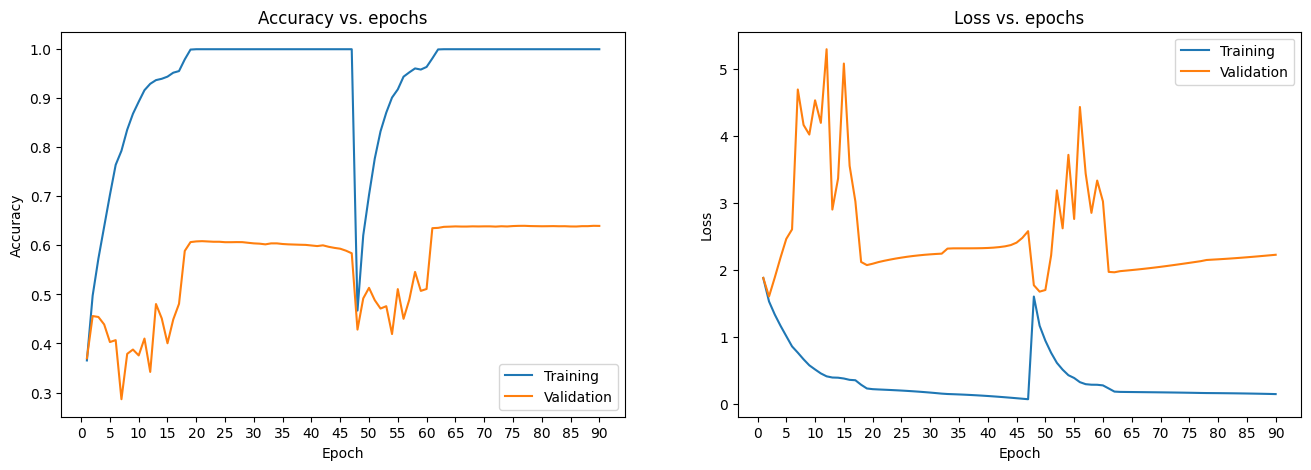

2022-08-16 09:00:53,621: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/resnet_v1_20
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 2s 6ms/step


2022-08-16 09:01:11,039: INFO: test loss:2.1340
2022-08-16 09:01:11,040: INFO: test accuracy:0.6399
2022-08-16 09:01:11,044: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/results.json
2022-08-16 09:01:11,046: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/results.json
2022-08-16 09:01:11,047: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/default.generator
2022-08-16 09:01:11,048: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/default.generator
2022-08-16 09:01:11,048: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-16 09:01:12,750: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/default.generator


313/313 [==============================] - 1s 3ms/step


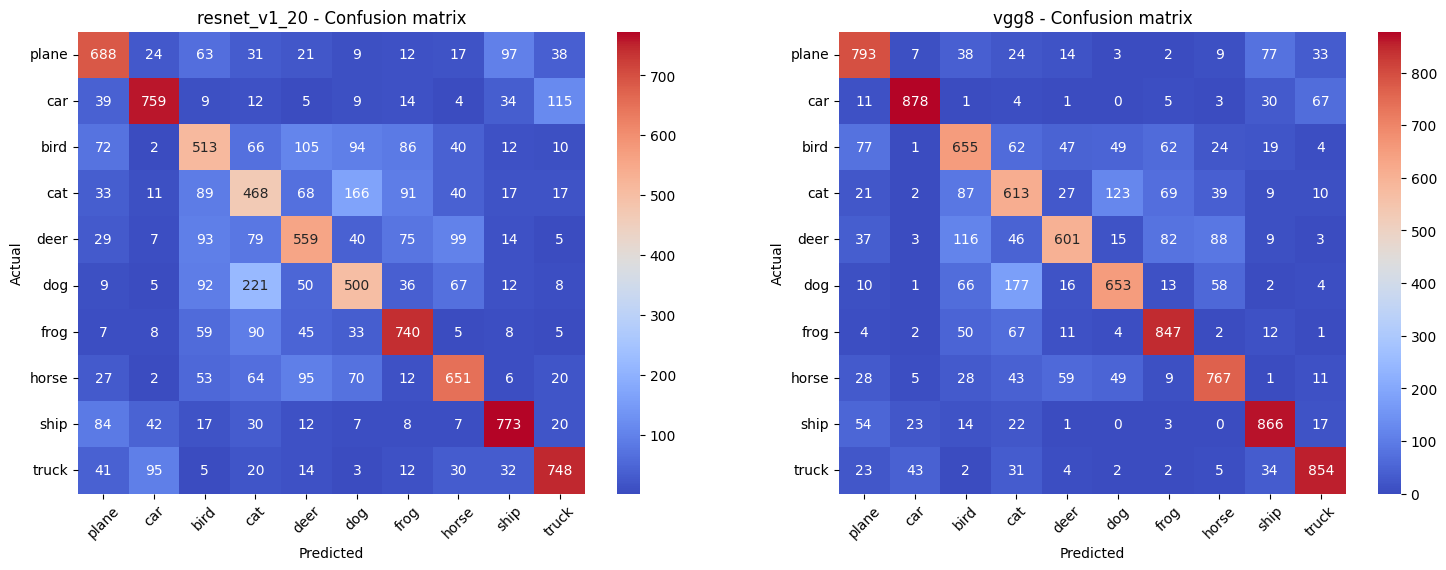

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  train_time  \
1          vgg8  cifar10_0816_cnt_1000.ipynb        1672906       435.9   
2       custom1  cifar10_0816_cnt_1000.ipynb          73738       246.7   
3  resnet_v1_20  cifar10_0816_cnt_1000.ipynb         273066       863.5   
4        lenet1  cifar10_0816_cnt_1000.ipynb          83170       209.3   
5          mlp1  cifar10_0816_cnt_1000.ipynb         394634       120.8   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-16 08:46      0.0137     1.3588          0.9992         0.7527   
2  2022-08-16 08:38      0.1393     1.0998          0.9655         0.6844   
3  2022-08-16 09:01      0.1716     2.1340          0.9992         0.6399   
4  2022-08-16 08:34      0.1788     1.3058          0.9571         0.6176   
5  2022-08-16 08:31      1.5023     1.7401          0.4654         0.3788   

   train_auc  test_auc  
1     1.0000    0.9586  
2     0.9991    0.9487  
3     1.0000    0.9294  
4     0.9988    0.9271  
5     0.8662    0.8141

In [29]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20, preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Pretrained Model + Fune-Tune

In [30]:
class ResizeLayer(tf.keras.layers.Layer):
    def __init__(self, shape):
        super(ResizeLayer, self).__init__()
        self.shape = shape

    def call(self, inputs, training=False):
#         print(type(inputs))
#         return tf.convert_to_tensor(resize_images(inputs.numpy(), self.shape))
        return tf.image.resize(inputs, self.shape)

In [31]:
rescale1 = tf.keras.layers.Rescaling(1./127.5, offset=-1)
input_shape = [160, 160, 3]

In [32]:
preprocess_fun =  [ResizeLayer(input_shape[:-1]), rescale1]

(32, 160, 160, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>


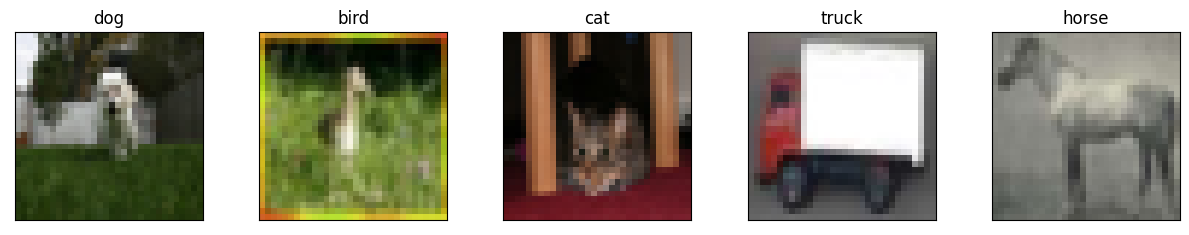

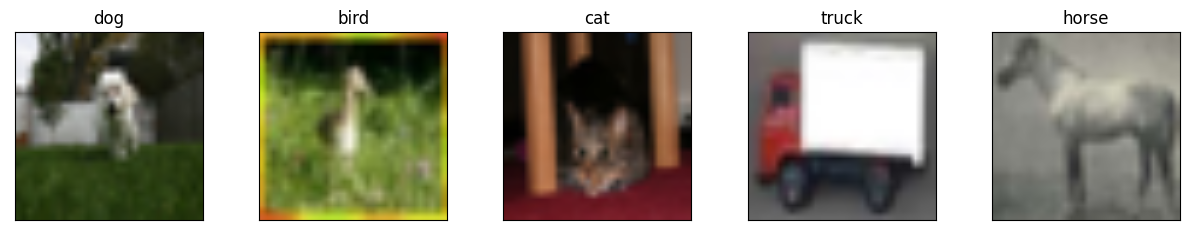

In [33]:
sample_images1 = ResizeLayer(input_shape[:-1])(sample_images)
print(sample_images1.shape, type(sample_images1)) 
qtf.utils.show_images(sample_images.numpy(), sample_labels, classes=params.classes, x_num=1, y_num=5, figsize=(12, 3))
qtf.utils.show_images(sample_images1.numpy(), sample_labels, classes=params.classes, x_num=1, y_num=5, figsize=(12, 3))

#### MobileNet V2

In [34]:
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_6[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [35]:
def pretrained_model(helper, base_model, dropout=None, name='pretrained_model', last_activation=None, preprocess_fun=None):
    if dropout is None:
        dropout = helper.params.get_model_param(name, 'dropout')

    input_shape = qbz95.tf.classification.get_input_shape(helper.datasets.train_dataset)
    input = layers.Input(shape=input_shape)
    x = qbz95.tf.classification.image_models.process_funs(input, preprocess_fun)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    if dropout > 0: x = layers.Dropout(dropout)(x)
    x = helper.get_dense_layer(len(helper.params.classes), activation=last_activation)(x)

    model = Model(inputs=input, outputs=x, name=name)
    helper.compile(model)
    return model

def fine_tuning(helper, model, base_model, fine_tune_at, learning_rate=0.00001):
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=helper.params.metrics)
    return model 

In [36]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = pretrained_model(helper, base_model, dropout=0.2, name='pretrained-MobileNetV2', preprocess_fun=preprocess_fun)
print(f'len(model.trainable_variables)={len(model.trainable_variables)}')
model.summary()

loss0, accuracy0 = model.evaluate(datasets.test_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

2022-08-16 09:01:21,539: INFO: model_params.pretrained-MobileNetV2.learning_rate=0.0001
2022-08-16 09:01:21,540: INFO: model_params.pretrained-MobileNetV2.clip_value=None
2022-08-16 09:01:21,549: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2


len(model.trainable_variables)=2
Model: "pretrained-MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resize_layer (ResizeLayer)  (None, 160, 160, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_10

2022-08-16 09:08:43,584: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2, monitor=val_accuracy)
2022-08-16 09:08:43,585: INFO: steps_per_epoch=312
2022-08-16 09:08:43,586: INFO: start training
2022-08-16 09:08:43,588: INFO: use_class_weight=False


Epoch 1/10
312/312 [==============================] - ETA: 0s - loss: 2.0225 - accuracy: 0.3198

2022-08-16 09:09:30,526: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


2022-08-16 09:09:35,519: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


312/312 [==============================] - 53s 160ms/step - loss: 2.0225 - accuracy: 0.3198 - val_loss: 1.2366 - val_accuracy: 0.6111
Epoch 2/10
311/312 [============================>.] - ETA: 0s - loss: 1.1286 - accuracy: 0.6214

2022-08-16 09:10:19,385: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


2022-08-16 09:10:24,468: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


312/312 [==============================] - 49s 157ms/step - loss: 1.1277 - accuracy: 0.6217 - val_loss: 0.8466 - val_accuracy: 0.7343
Epoch 3/10
312/312 [==============================] - ETA: 0s - loss: 0.8608 - accuracy: 0.7136

2022-08-16 09:11:08,773: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


2022-08-16 09:11:13,817: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


312/312 [==============================] - 49s 158ms/step - loss: 0.8608 - accuracy: 0.7136 - val_loss: 0.7028 - val_accuracy: 0.7769
Epoch 4/10
310/312 [============================>.] - ETA: 0s - loss: 0.7337 - accuracy: 0.7504

2022-08-16 09:11:47,609: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


2022-08-16 09:11:53,025: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


312/312 [==============================] - 39s 126ms/step - loss: 0.7325 - accuracy: 0.7507 - val_loss: 0.6315 - val_accuracy: 0.7939
Epoch 5/10
311/312 [============================>.] - ETA: 0s - loss: 0.6617 - accuracy: 0.7783

2022-08-16 09:12:28,898: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


2022-08-16 09:12:34,179: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


312/312 [==============================] - 42s 134ms/step - loss: 0.6614 - accuracy: 0.7784 - val_loss: 0.5867 - val_accuracy: 0.8046
Epoch 6/10
311/312 [============================>.] - ETA: 0s - loss: 0.6186 - accuracy: 0.7900

2022-08-16 09:13:10,757: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


2022-08-16 09:13:15,721: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


312/312 [==============================] - 41s 132ms/step - loss: 0.6183 - accuracy: 0.7902 - val_loss: 0.5563 - val_accuracy: 0.8128
Epoch 7/10
311/312 [============================>.] - ETA: 0s - loss: 0.5742 - accuracy: 0.8053

2022-08-16 09:13:49,814: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


2022-08-16 09:13:54,694: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


312/312 [==============================] - 39s 125ms/step - loss: 0.5740 - accuracy: 0.8054 - val_loss: 0.5356 - val_accuracy: 0.8200
Epoch 8/10
312/312 [==============================] - ETA: 0s - loss: 0.5442 - accuracy: 0.8139

2022-08-16 09:14:31,635: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


2022-08-16 09:14:36,791: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


312/312 [==============================] - 42s 135ms/step - loss: 0.5442 - accuracy: 0.8139 - val_loss: 0.5186 - val_accuracy: 0.8246
Epoch 9/10
312/312 [==============================] - ETA: 0s - loss: 0.5231 - accuracy: 0.8202

2022-08-16 09:15:12,801: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


2022-08-16 09:15:17,658: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


312/312 [==============================] - 41s 131ms/step - loss: 0.5231 - accuracy: 0.8202 - val_loss: 0.5052 - val_accuracy: 0.8287
Epoch 10/10
311/312 [============================>.] - ETA: 0s - loss: 0.5099 - accuracy: 0.8223

2022-08-16 09:15:54,444: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


2022-08-16 09:15:59,368: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


312/312 [==============================] - 42s 134ms/step - loss: 0.5097 - accuracy: 0.8224 - val_loss: 0.4944 - val_accuracy: 0.8296


2022-08-16 09:16:00,189: INFO: finish training [elapsed time: 436.60 seconds]


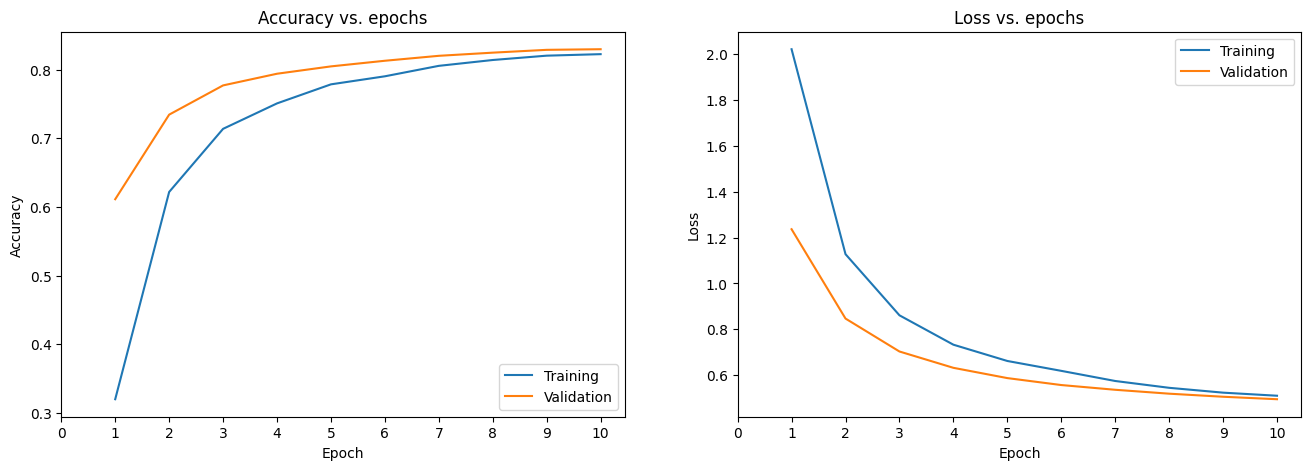

In [38]:
history = helper.train(model, epochs=10, callbacks=helper.get_callbacks(model, params.pretrained_callbacks))

In [39]:
model = fine_tuning(helper, model, base_model, fine_tune_at=100, learning_rate=0.00001)
print(f'len(model.trainable_variables)={len(model.trainable_variables)}')

len(model.trainable_variables)=56


2022-08-16 09:16:00,715: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2, monitor=val_accuracy)
2022-08-16 09:16:00,717: INFO: steps_per_epoch=312
2022-08-16 09:16:00,718: INFO: start training
2022-08-16 09:16:00,718: INFO: use_class_weight=False


Epoch 1/15
312/312 [==============================] - ETA: 0s - loss: 0.4582 - accuracy: 0.8415

2022-08-16 09:16:50,917: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


2022-08-16 09:16:56,122: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


312/312 [==============================] - 56s 162ms/step - loss: 0.4582 - accuracy: 0.8415 - val_loss: 0.4262 - val_accuracy: 0.8541
Epoch 2/15
312/312 [==============================] - ETA: 0s - loss: 0.3598 - accuracy: 0.8765

2022-08-16 09:17:42,920: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


2022-08-16 09:17:48,619: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


312/312 [==============================] - 52s 169ms/step - loss: 0.3598 - accuracy: 0.8765 - val_loss: 0.4049 - val_accuracy: 0.8633
Epoch 3/15
312/312 [==============================] - ETA: 0s - loss: 0.2933 - accuracy: 0.8988

2022-08-16 09:18:35,255: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


2022-08-16 09:18:40,979: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


312/312 [==============================] - 52s 168ms/step - loss: 0.2933 - accuracy: 0.8988 - val_loss: 0.3837 - val_accuracy: 0.8691
Epoch 4/15
312/312 [==============================] - ETA: 0s - loss: 0.2420 - accuracy: 0.9138

2022-08-16 09:19:28,891: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


2022-08-16 09:19:34,240: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


312/312 [==============================] - 53s 171ms/step - loss: 0.2420 - accuracy: 0.9138 - val_loss: 0.3779 - val_accuracy: 0.8729
Epoch 5/15
312/312 [==============================] - ETA: 0s - loss: 0.2000 - accuracy: 0.9314

2022-08-16 09:20:17,028: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


2022-08-16 09:20:22,185: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


312/312 [==============================] - 48s 154ms/step - loss: 0.2000 - accuracy: 0.9314 - val_loss: 0.3691 - val_accuracy: 0.8781
Epoch 6/15
311/312 [============================>.] - ETA: 0s - loss: 0.1612 - accuracy: 0.9452

2022-08-16 09:21:05,125: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


2022-08-16 09:21:10,365: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


312/312 [==============================] - 48s 155ms/step - loss: 0.1612 - accuracy: 0.9451 - val_loss: 0.3766 - val_accuracy: 0.8784
Epoch 7/15
312/312 [==============================] - ETA: 0s - loss: 0.1320 - accuracy: 0.9570

2022-08-16 09:21:51,425: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


2022-08-16 09:21:56,438: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


312/312 [==============================] - 46s 148ms/step - loss: 0.1320 - accuracy: 0.9570 - val_loss: 0.3853 - val_accuracy: 0.8790
Epoch 8/15
311/312 [============================>.] - ETA: 0s - loss: 0.1050 - accuracy: 0.9667

2022-08-16 09:22:33,116: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


2022-08-16 09:22:38,124: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


312/312 [==============================] - 42s 134ms/step - loss: 0.1051 - accuracy: 0.9666 - val_loss: 0.3784 - val_accuracy: 0.8852
Epoch 9/15
312/312 [==============================] - 21s 67ms/step - loss: 0.0828 - accuracy: 0.9765 - val_loss: 0.3894 - val_accuracy: 0.8824
Epoch 10/15
311/312 [============================>.] - ETA: 0s - loss: 0.0647 - accuracy: 0.9815

2022-08-16 09:23:37,732: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


2022-08-16 09:23:42,720: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


312/312 [==============================] - 44s 141ms/step - loss: 0.0646 - accuracy: 0.9816 - val_loss: 0.3874 - val_accuracy: 0.8897
Epoch 11/15
312/312 [==============================] - 21s 67ms/step - loss: 0.0528 - accuracy: 0.9860 - val_loss: 0.4247 - val_accuracy: 0.8818
Epoch 12/15
312/312 [==============================] - 21s 67ms/step - loss: 0.0405 - accuracy: 0.9904 - val_loss: 0.4160 - val_accuracy: 0.8895
Epoch 13/15
311/312 [============================>.] - ETA: 0s - loss: 0.0330 - accuracy: 0.9917

2022-08-16 09:25:03,364: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


2022-08-16 09:25:08,358: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2/assets


312/312 [==============================] - 44s 141ms/step - loss: 0.0329 - accuracy: 0.9917 - val_loss: 0.4112 - val_accuracy: 0.8930
Epoch 14/15
312/312 [==============================] - 20s 64ms/step - loss: 0.0251 - accuracy: 0.9955 - val_loss: 0.4347 - val_accuracy: 0.8899
Epoch 15/15
312/312 [==============================] - 30s 96ms/step - loss: 0.0207 - accuracy: 0.9954 - val_loss: 0.4525 - val_accuracy: 0.8892


2022-08-16 09:25:59,076: INFO: finish training [elapsed time: 598.36 seconds]


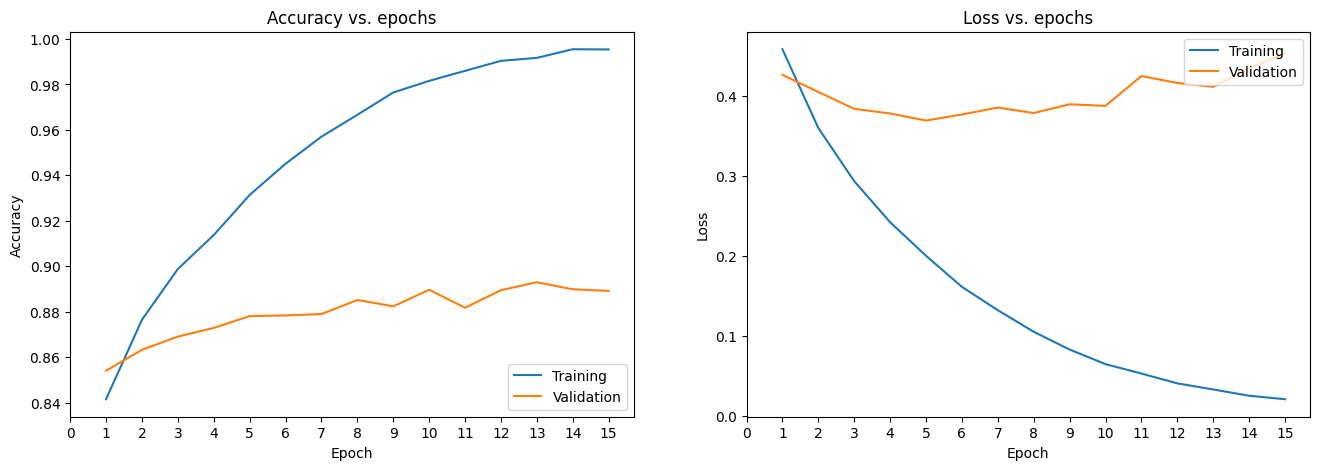

2022-08-16 09:25:59,477: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 6s 20ms/step


2022-08-16 09:26:44,788: INFO: test loss:0.4112
2022-08-16 09:26:44,789: INFO: test accuracy:0.8930
2022-08-16 09:26:44,792: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/results.json
2022-08-16 09:26:44,794: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/results.json
2022-08-16 09:26:44,794: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/default.generator
2022-08-16 09:26:44,796: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/default.generator
2022-08-16 09:26:44,796: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-16 09:26:46,382: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/default.generator


313/313 [==============================] - 1s 3ms/step


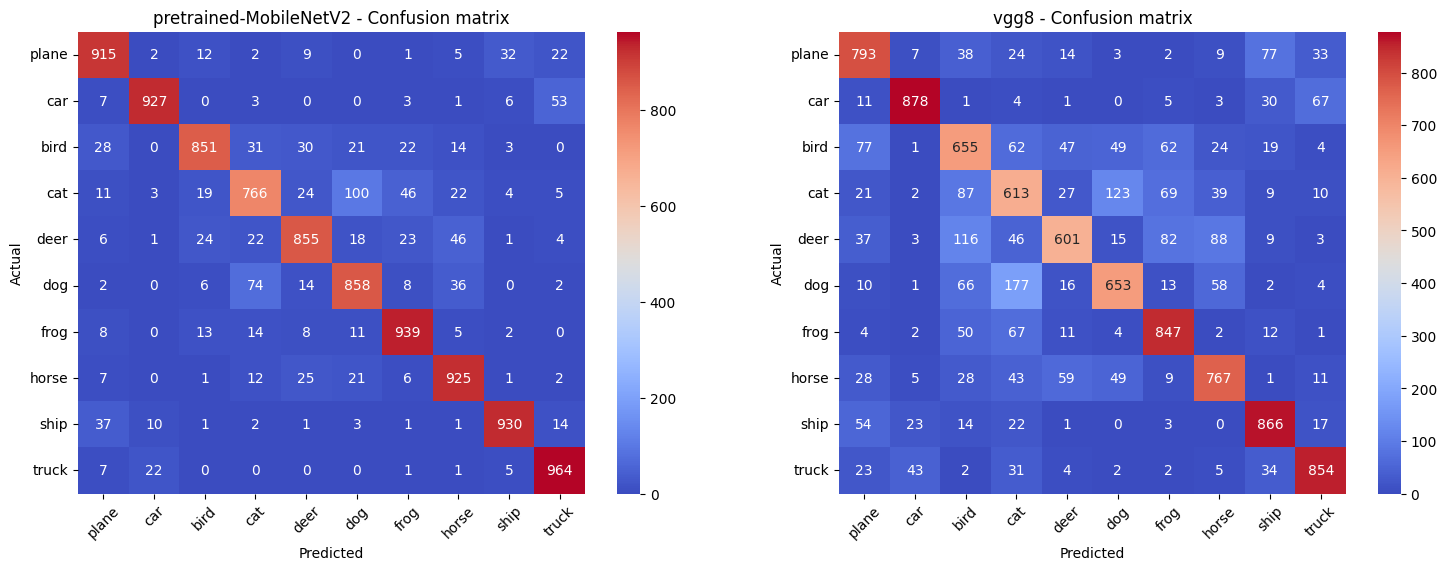

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  \
1  pretrained-MobileNetV2  cifar10_0816_cnt_1000.ipynb        1874250   
2                    vgg8  cifar10_0816_cnt_1000.ipynb        1672906   
3                 custom1  cifar10_0816_cnt_1000.ipynb          73738   
4            resnet_v1_20  cifar10_0816_cnt_1000.ipynb         273066   
5                  lenet1  cifar10_0816_cnt_1000.ipynb          83170   
6                    mlp1  cifar10_0816_cnt_1000.ipynb         394634   

   train_time       create_time  train_loss  test_loss  train_accuracy  \
1       598.4  2022-08-16 09:26      0.0212     0.4112          0.9963   
2       435.9  2022-08-16 08:46      0.0137     1.3588          0.9992   
3       246.7  2022-08-16 08:38      0.1393     1.0998          0.9655   
4       863.5  2022-08-16 09:01      0.1716     2.1340          0.9992   
5       209.3  2022-08-16 08:34      0.1788     1.3058          0.9571   
6       120.8  2022-08-16 08:31      1.5023     1.7401          0.4654   

   test_accuracy  train_auc  test_auc  
1         0.8930     1.0000    0.9929  
2         0.7527     1.0000    0.9586  
3         0.6844     0.9991    0.9487  
4         0.6399     1.0000    0.9294  
5         0.6176     0.9988    0.9271  
6         0.3788     0.8662    0.8141

In [40]:
history = helper.train(model, epochs=15, callbacks=helper.get_callbacks(model, params.pretrained_callbacks))
helper.model_summary(model, history, show_sample_analysis=False) 

## Evaluation

### Best Model

In [49]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

2022-08-16 09:34:09,482: INFO: getting results for /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10
2022-08-16 09:34:09,484: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/results.json
2022-08-16 09:34:09,485: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/results.json
2022-08-16 09:34:09,486: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/results.json
2022-08-16 09:34:09,487: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/results.json


model_name                 program_name  weight_number  \
1   pretrained-MobileNetV2  cifar10_0816_cnt_1000.ipynb        1874250   
2                     vgg8  cifar10_0816_cnt_1000.ipynb        1672906   
3                     vgg8   cifar10_0816_cnt_500.ipynb        1672906   
4                  custom1  cifar10_0816_cnt_1000.ipynb          73738   
5             resnet_v1_20  cifar10_0816_cnt_1000.ipynb         273066   
6                  custom1   cifar10_0816_cnt_500.ipynb          73738   
7                   lenet1  cifar10_0816_cnt_1000.ipynb          83170   
8                     vgg8   cifar10_0816_cnt_200.ipynb        1672906   
9                  custom1   cifar10_0816_cnt_200.ipynb          73738   
10            resnet_v1_20   cifar10_0816_cnt_500.ipynb         273066   

    train_time       create_time  train_loss  test_loss  train_accuracy  \
1        598.4  2022-08-16 09:26      0.0212     0.4112          0.9963   
2        435.9  2022-08-16 08:46      0.0137     1.3588          0.9992   
3        497.7  2022-08-16 09:10      0.0072     1.6269          0.9992   
4        246.7  2022-08-16 08:38      0.1393     1.0998          0.9655   
5        863.5  2022-08-16 09:01      0.1716     2.1340          0.9992   
6        218.9  2022-08-16 09:01      0.0772     1.4183          0.9882   
7        209.3  2022-08-16 08:34      0.1788     1.3058          0.9571   
8        407.1  2022-08-16 09:10      0.0139     1.9241          0.9970   
9        199.7  2022-08-16 09:03      0.0607     1.7251          0.9925   
10       872.3  2022-08-16 09:25      0.3798     1.6719          0.9262   

    test_accuracy  train_auc  test_auc  
1          0.8930     1.0000    0.9929  
2          0.7527     1.0000    0.9586  
3          0.7000     1.0000    0.9473  
4          0.6844     0.9991    0.9487  
5          0.6399     1.0000    0.9294  
6          0.6246     0.9998    0.9292  
7          0.6176     0.9988    0.9271  
8          0.6089     1.0000    0.9188  
9          0.5400     0.9999    0.8987  
10         0.5357     0.9967    0.8983

In [50]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

2022-08-16 09:34:09,566: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2
2022-08-16 09:34:21,894: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/default.generator
2022-08-16 09:34:21,912: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/vgg8
2022-08-16 09:34:23,566: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/default.generator
2022-08-16 09:34:23,569: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8
2022-08-16 09:34:25,105: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_no

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


None

In [51]:
predictors[0].classes

['plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

1/1 [==============================] - 0s 162ms/step


2022-08-16 09:34:32,260: WARNING: 5 out of the last 317 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa4e43f74c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 132ms/step


2022-08-16 09:34:32,761: WARNING: 6 out of the last 318 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa4a6c185e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 15ms/step


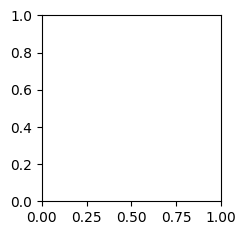

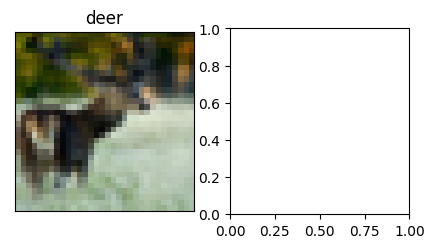

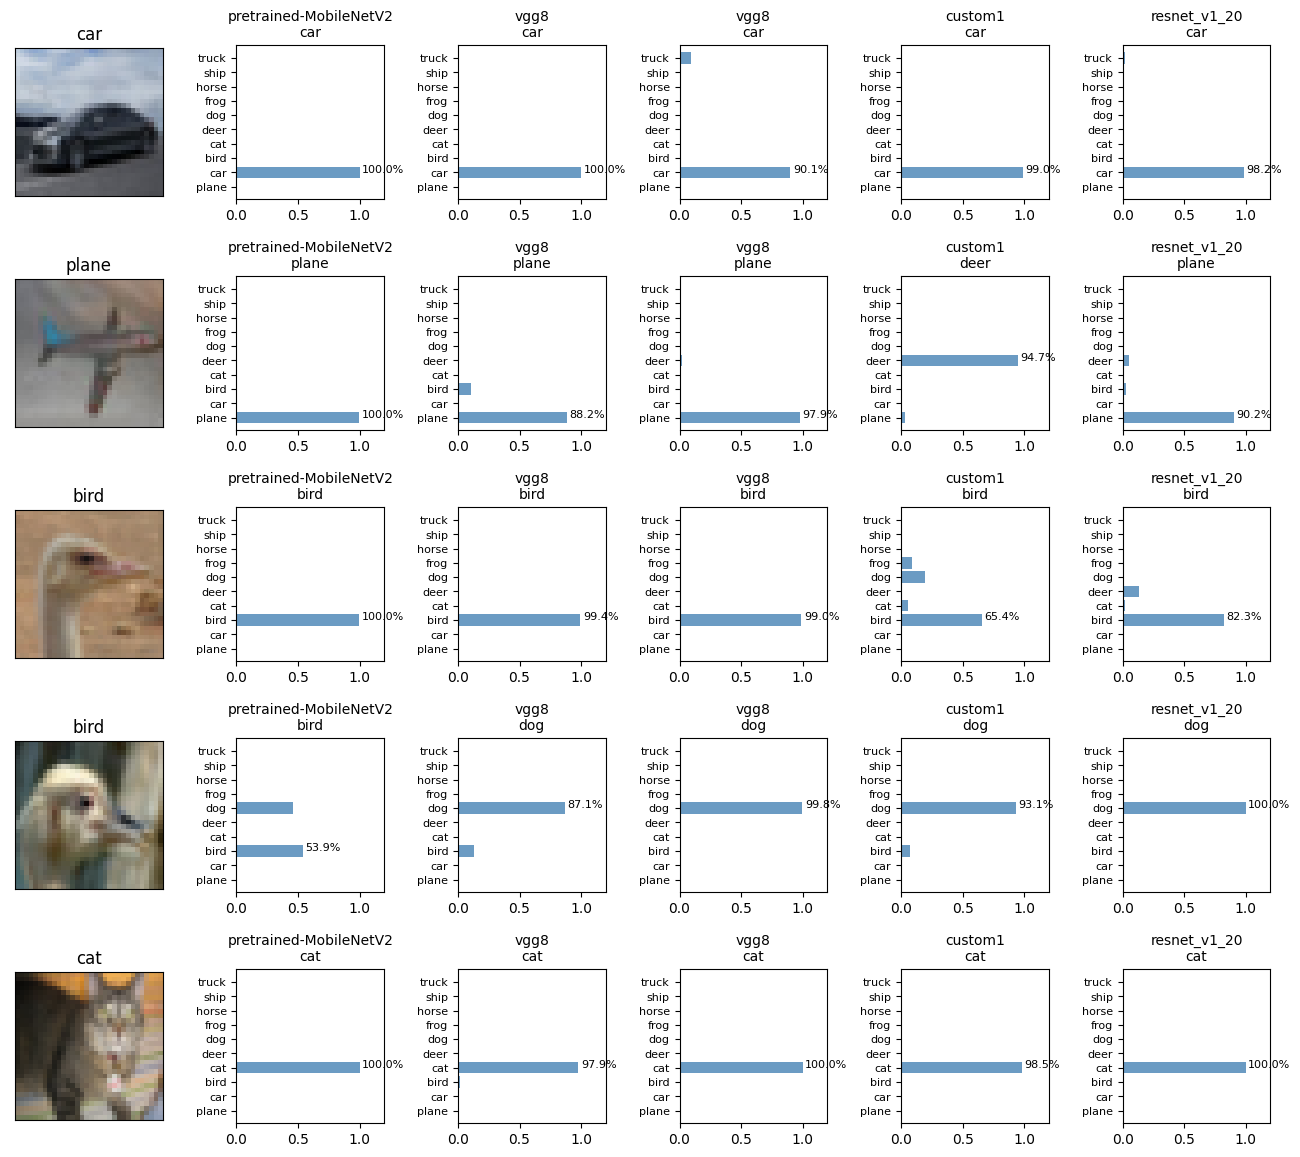

In [52]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                     sample_count=5, show_error_sample=False) 

1/1 [==============================] - 0s 16ms/step


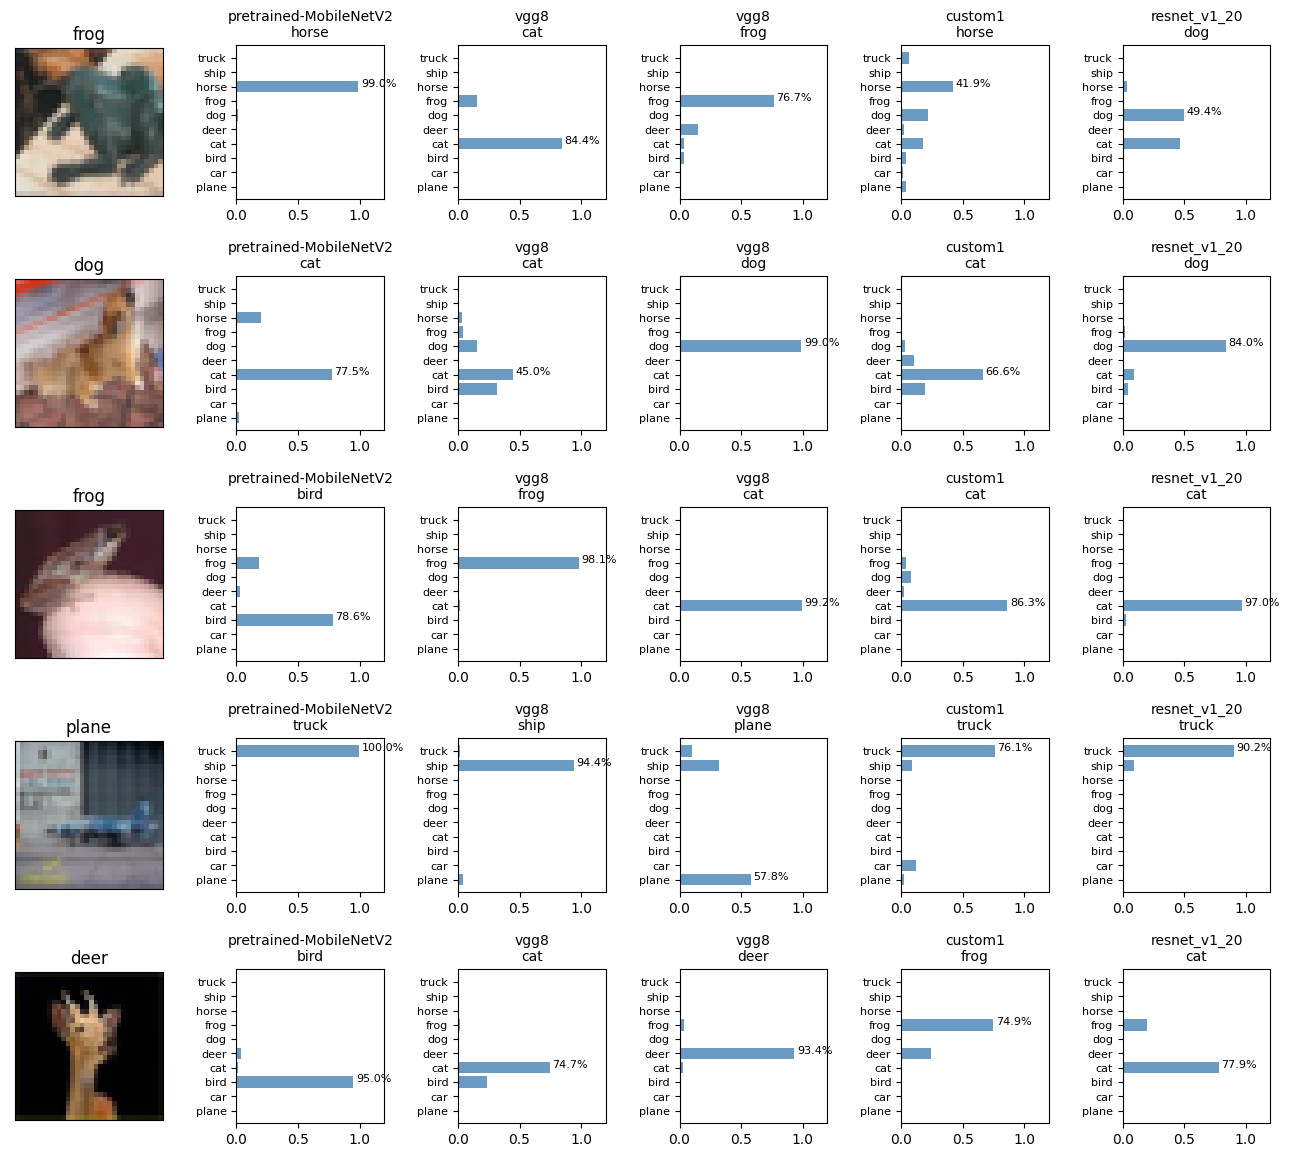

In [53]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### Evaluate

In [54]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

{'loss': 0.41117557883262634, 'accuracy': 0.8930000066757202, 'mae': 10.240538597106934}
313/313 [==============================] - 6s 20ms/step
(10000, 10)


In [55]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

313/313 [==============================] - 6s 20ms/step


precision  recall        f1
plane   0.890078   0.915  0.902367
car     0.960622   0.927  0.943511
bird    0.918015   0.851  0.883238
cat     0.827214   0.766  0.795431
deer    0.885093   0.855  0.869786
dog     0.831395   0.858  0.844488
frog    0.894286   0.939  0.916098
horse   0.875947   0.925  0.899805
ship    0.945122   0.930  0.937500
truck   0.904315   0.964  0.933204

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

       plane     0.8901    0.9150    0.9024      1000
         car     0.9606    0.9270    0.9435      1000
        bird     0.9180    0.8510    0.8832      1000
         cat     0.8272    0.7660    0.7954      1000
        deer     0.8851    0.8550    0.8698      1000
         dog     0.8314    0.8580    0.8445      1000
        frog     0.8943    0.9390    0.9161      1000
       horse     0.8759    0.9250    0.8998      1000
        ship     0.9451    0.9300    0.9375      1000
       truck     0.9043    0.9640    0.9332      1000

    accuracy                         0.8930     10000
   macro avg     0.8932    0.8930    0.8925     10000
weighted avg     0.8932    0.8930    0.8925     10000



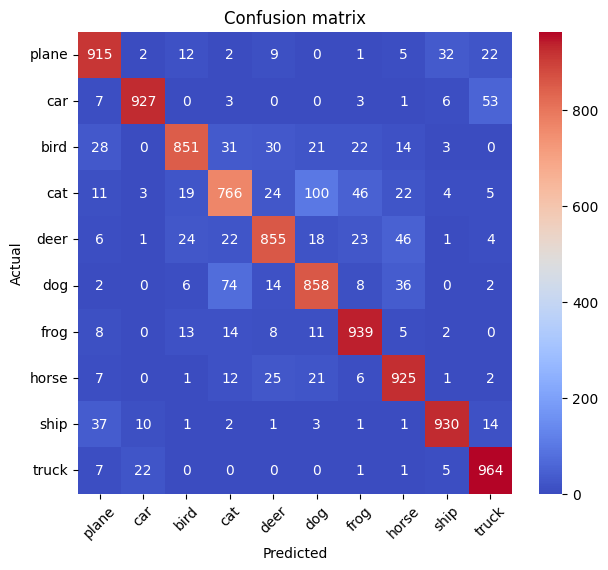

In [56]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## Reference

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)